In [1]:
# Advance Lane Finding

In [2]:
#1.-Camera Calibartion

In [3]:
from moviepy.editor import VideoFileClip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
import os
%matplotlib inline

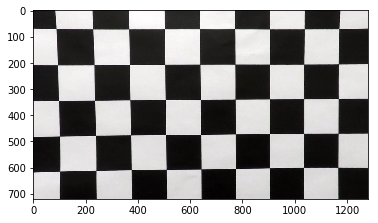

In [4]:
images = glob.glob('camera_cal/calibration*.jpg')
object_points = [] #real points 3D
image_points = [] #point of the different images 2D

obj_points = np.zeros((6*9,3), np.float32)
obj_points[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
total = 0
for image in images:
    
    #read each image
    img = mpimg.imread(image) 

    #convert to gray scale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    #find corner for the cheesboard
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret == True:
        image_points.append(corners)
        object_points.append(obj_points)

#calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, gray.shape[::-1], None, None)

#test the calibration a plot image1
test_image = mpimg.imread('camera_cal/calibration1.jpg') 
dst = cv2.undistort(test_image, mtx, dist, None, mtx)
plt.imshow(dst)



In [5]:
test_image = mpimg.imread('test_images/straight_lines1.jpg') 
dst = cv2.undistort(test_image, mtx, dist, None, mtx)


In [6]:
#2.- COLOR TRANSFORM, GRADIENTS FOR BINARY IMAGE

In [7]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def get_binary_filtered_img(path,mtx, dist, saturation_thresh=(170, 255), sobel_thresh=(20, 100), light_thresh=(0,80)):
    
    #reading in an image
    if type(path) == type("String"):
        img = mpimg.imread(path)
    else:
        img = path
    
    undist_image = cv2.undistort(img, mtx, dist, None, mtx)
    # Apply the following steps to img
    # Convert to hls color space
    hls = cv2.cvtColor(undist_image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    
    #calculating sobel for X
    sobel_x = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0)
    # Take the absolute value of the derivative or gradient
    abs_sobel_x = np.absolute(sobel_x)
    
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))
    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1
    
    # Threshold color channel
    saturation_binary = np.zeros_like(s_channel)
    saturation_binary[(s_channel >= saturation_thresh[0]) & (s_channel <= saturation_thresh[1])] = 1
    
    light_binary = np.zeros_like(l_channel)
    light_binary[(l_channel >= light_thresh[0]) & (l_channel <= light_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sobel_binary), sobel_binary, sobel_binary)) * 255
    combined_binary_1 = np.zeros_like(sobel_binary)
    combined_binary_1[(saturation_binary == 1) | (sobel_binary == 1)] = 1
    combined_binary = np.zeros_like(sobel_binary)
    combined_binary[((saturation_binary == 1) | (sobel_binary == 1)) & (light_binary == 1)] = 1
    # 6) Return this mask as your binary_output image
    '''fig = plt.figure(figsize=(20, 20))
    fig.add_subplot(2, 2, 1)
    plt.imshow(img)
    fig.add_subplot(2, 2, 2)
    plt.imshow(combined_binary_1, cmap= 'gray')
    fig.add_subplot(2, 2, 3)
    plt.imshow(combined_binary, cmap= 'gray')
    fig.add_subplot(2, 2, 4)
    plt.imshow((combined_binary - combined_binary_1), cmap= 'gray')'''
    
    
    return combined_binary, undist_image

binary_images = {}
undistorted_images = {}

list_images = os.listdir("test_images/")
for file in list_images:
    path_image = "test_images/"+file
    f_binary_image, undist_image  = get_binary_filtered_img(path_image, mtx, dist, saturation_thresh=(180, 255), sobel_thresh=(20, 80), light_thresh=(50,255))
    binary_images["binary_"+file] = f_binary_image
    undistorted_images ["undist_"+file] = undist_image
    

#plt.imshow(grad_binary, cmap='gray')

In [8]:
#3.-PERSPECTIVE TRANSFORM

In [9]:
def prespective_transform(img, source_point, destination_point):
    
    #transforming binary image to 3d image for drawing color lines
    img_with_lines_s = np.dstack(( img, img, img))* 255
    
    #parameters for color lines
    color=[255, 0, 0]
    thickness=4
    
    
    #Drawings color lines for source
    cv2.line(img_with_lines_s, (source_point[0,0], source_point[0,1]), (source_point[1,0], source_point[1,1]), color, thickness)
    cv2.line(img_with_lines_s, (source_point[1,0], source_point[1,1]), (source_point[2,0], source_point[2,1]), color, thickness)
    cv2.line(img_with_lines_s, (source_point[2,0], source_point[2,1]), (source_point[3,0], source_point[3,1]), color, thickness)
    cv2.line(img_with_lines_s, (source_point[3,0], source_point[3,1]), (source_point[0,0], source_point[0,1]), color, thickness)
    
    
    img_size = (img.shape[1],img.shape[0])
    Warped_matrix = cv2.getPerspectiveTransform(source_point,destination_point)
    image_warpe = cv2.warpPerspective(img, Warped_matrix, img_size)
    
    #transforming binary image to 3d image for drawing color lines
    image_warpe_with_lines = np.dstack(( image_warpe, image_warpe, image_warpe))* 255
    
    #Drawings color lines for destination
    cv2.line(image_warpe_with_lines, (destination_point[0,0], destination_point[0,1]), (destination_point[1,0], destination_point[1,1]), color, thickness)
    cv2.line(image_warpe_with_lines, (destination_point[1,0], destination_point[1,1]), (destination_point[2,0], destination_point[2,1]), color, thickness)
    cv2.line(image_warpe_with_lines, (destination_point[2,0], destination_point[2,1]), (destination_point[3,0], destination_point[3,1]), color, thickness)
    cv2.line(image_warpe_with_lines, (destination_point[3,0], destination_point[3,1]), (destination_point[0,0], destination_point[0,1]), color, thickness)
    
    #print figures
    '''fig = plt.figure(figsize=(20, 20))
    fig.add_subplot(1, 2, 1)
    plt.imshow(img_with_lines_s, cmap='gray')
    fig.add_subplot(1, 2, 2)
    plt.imshow(image_warpe_with_lines, cmap='gray')'''
    #plt.show()
    
    return image_warpe

#Source points
x1_s = 200
x2_s = 555
x3_s = 732
x4_s = 1100
y_top_s = 720
y_low_s = 480
#generating the array for source points
src = np.float32([[x1_s, y_top_s],[x2_s, y_low_s],[x3_s, y_low_s],[x4_s, y_top_s]])

#destination points
x_low_d = 290
x_top_d = 990
y_top_d = 720
y_low_d = 0
#generating the array for destination points
dst = np.float32([[x_low_d, y_top_d],[x_low_d, y_low_d],[x_top_d, y_low_d],[x_top_d, y_top_d]])

prespective_images = {}
fig = plt.figure(figsize=(100, 100))
for key, image in binary_images.items() :
    print (key)
    f_prespective_image = prespective_transform(image,src,dst)
    prespective_images["presp_"+key] = f_prespective_image
    

binary_test3.jpg
binary_test4.jpg
binary_straight_lines1.jpg
binary_test2.jpg
binary_straight_lines2.jpg
binary_test1.jpg
binary_test5.jpg
binary_test6.jpg


<Figure size 7200x7200 with 0 Axes>

In [10]:
#4.- SLIDING WINDOW DRAWING RECTANGLES

presp_binary_test3.jpg
presp_binary_test4.jpg
presp_binary_straight_lines1.jpg
presp_binary_test2.jpg
presp_binary_straight_lines2.jpg
presp_binary_test1.jpg
presp_binary_test5.jpg
presp_binary_test6.jpg


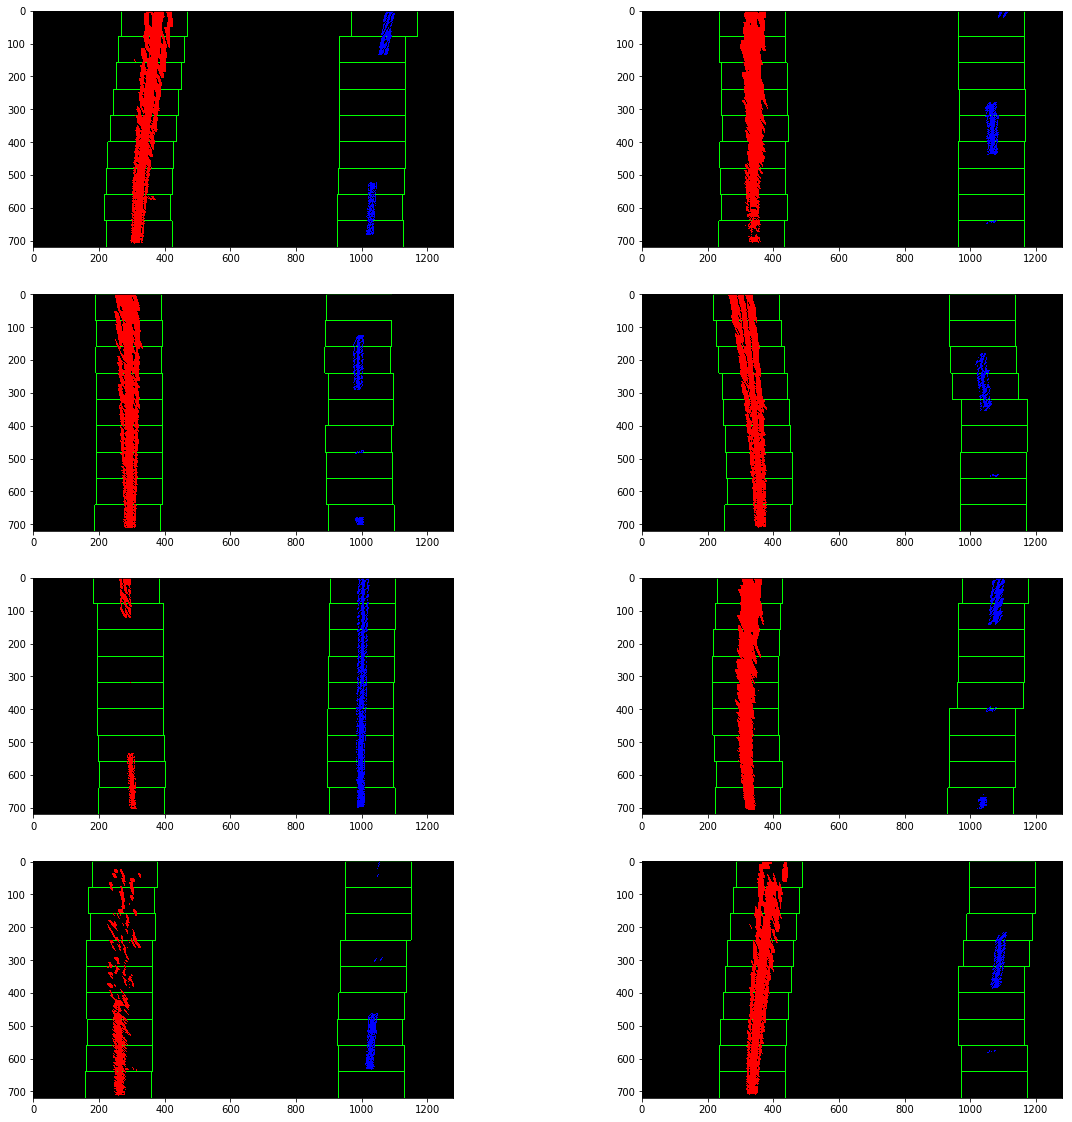

In [11]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        #Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &( nonzerox < win_xright_high)).nonzero()[0]
        
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    #Fit a second order polynomial to each using `np.polyfit` ###
    try:
        left_fit = np.polyfit(lefty,leftx,2)
        right_fit = np.polyfit(righty,rightx,2)
    except TypeError:
        left_fit = np.array([0,0,0])
        right_fit = np.array([0,0,0])
        pass


    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return binary_warped, out_img, left_fit, right_fit, left_fitx, right_fitx, ploty

poly_fit_images = {}
fig = plt.figure(figsize=(20, 20))
count = 1
for key, image in prespective_images.items() :
    print (key)
    fig.add_subplot(4, 2, count)
    poly_fit_images[key] = fit_polynomial(image)
    plt.imshow(poly_fit_images[key][1])
    count += 1

    

In [12]:
#5.- SEARCH FROM PREVIOUS POLYFIT RESULT AND CURVATURE CALCULATION

presp_binary_test3.jpg
presp_binary_test4.jpg
presp_binary_straight_lines1.jpg
presp_binary_test2.jpg
presp_binary_straight_lines2.jpg
presp_binary_test1.jpg
presp_binary_test5.jpg
presp_binary_test6.jpg


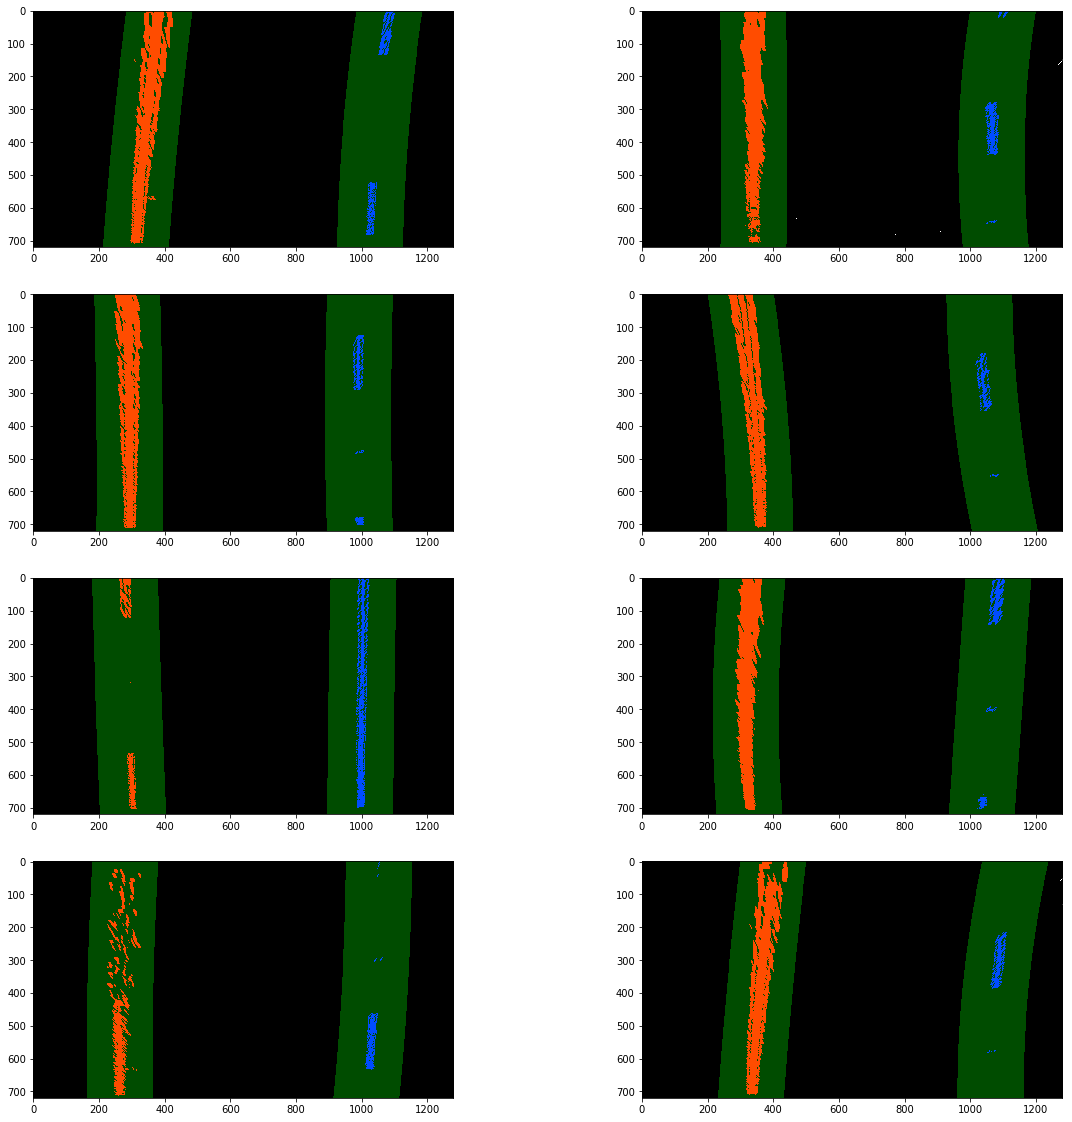

In [13]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###
    try:
        left_fit = np.polyfit(lefty,leftx,2)
        right_fit = np.polyfit(righty,rightx,2)
    except TypeError:
        left_fit = np.array([0,0,0])
        right_fit = np.array([0,0,0])
        pass
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #Calculation the Curvature
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    try:
        left_fit_m = np.polyfit(lefty*ym_per_pix,leftx*xm_per_pix,2)
        right_fit_m = np.polyfit(righty*ym_per_pix,rightx*xm_per_pix,2)
    except TypeError:
        left_fit_m = np.array([0,0,0])
        right_fit_m = np.array([0,0,0])
        pass
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image in m
    y_eval_m = y_eval * ym_per_pix
    
    ##### Implement the calculation of R_curve (radius of curvature) from f(y) = Ay^2 + By + C  f'(y) = 2Ay + B  f''(y) = 2A#####
    #Rcurve = ([1+ (dx/dy)^2]^(3/2))/(|(d2x/dy2)|) = ([1+ (2Ay + B)^2]^(3/2))/(|2A|)
    left_curve_rad = np.power((1+np.power(2*left_fit[0]*y_eval+left_fit[1],2)),(3/2))/np.absolute(2*left_fit[0]) 
    right_curve_rad = np.power((1+np.power(2*right_fit[0]*y_eval+right_fit[1],2)),(3/2))/np.absolute(2*right_fit[0])   
    #print(left_curve_rad, right_curve_rad)
    
    ### Real world calculation
    left_curve_rad_m = np.power((1+np.power(2*left_fit_m[0]*y_eval_m*+left_fit_m[1],2)),(3/2))/np.absolute(2*left_fit_m[0])  
    right_curve_rad_m = np.power((1+np.power(2*right_fit_m[0]*y_eval_m+right_fit_m[1],2)),(3/2))/np.absolute(2*right_fit_m[0])   
    #print(left_curve_rad_m, 'm', right_curve_rad_m, 'm')
    
    
    
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    return left_fitx, right_fitx, ploty, left_fit, right_fit, left_curve_rad_m, right_curve_rad_m

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #Set the area of search based on activated x-values ###

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit_new, right_fit_new, left_curve_rad_m, right_curve_rad_m = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx, ploty, left_fit_new, right_fit_new, left_curve_rad_m, right_curve_rad_m

#DU -Don't use it
search_around_poly_out = {}
fig = plt.figure(figsize=(20, 20))
count = 1
#poly_fit_images_items tuple contains binary_warped, out_img, left_fit, right_fit
for key, poly_fit_images_items in poly_fit_images.items() :
    print(key)
    fig.add_subplot(4, 2, count)
    search_around_poly_out[key] = search_around_poly(poly_fit_images_items[0],poly_fit_images_items[2],poly_fit_images_items[3])
    plt.imshow(search_around_poly_out[key][0])
    count += 1
    


In [14]:
#6.- DRAWING LINES REGION IN UNDISTORTED COLOR IMAGE

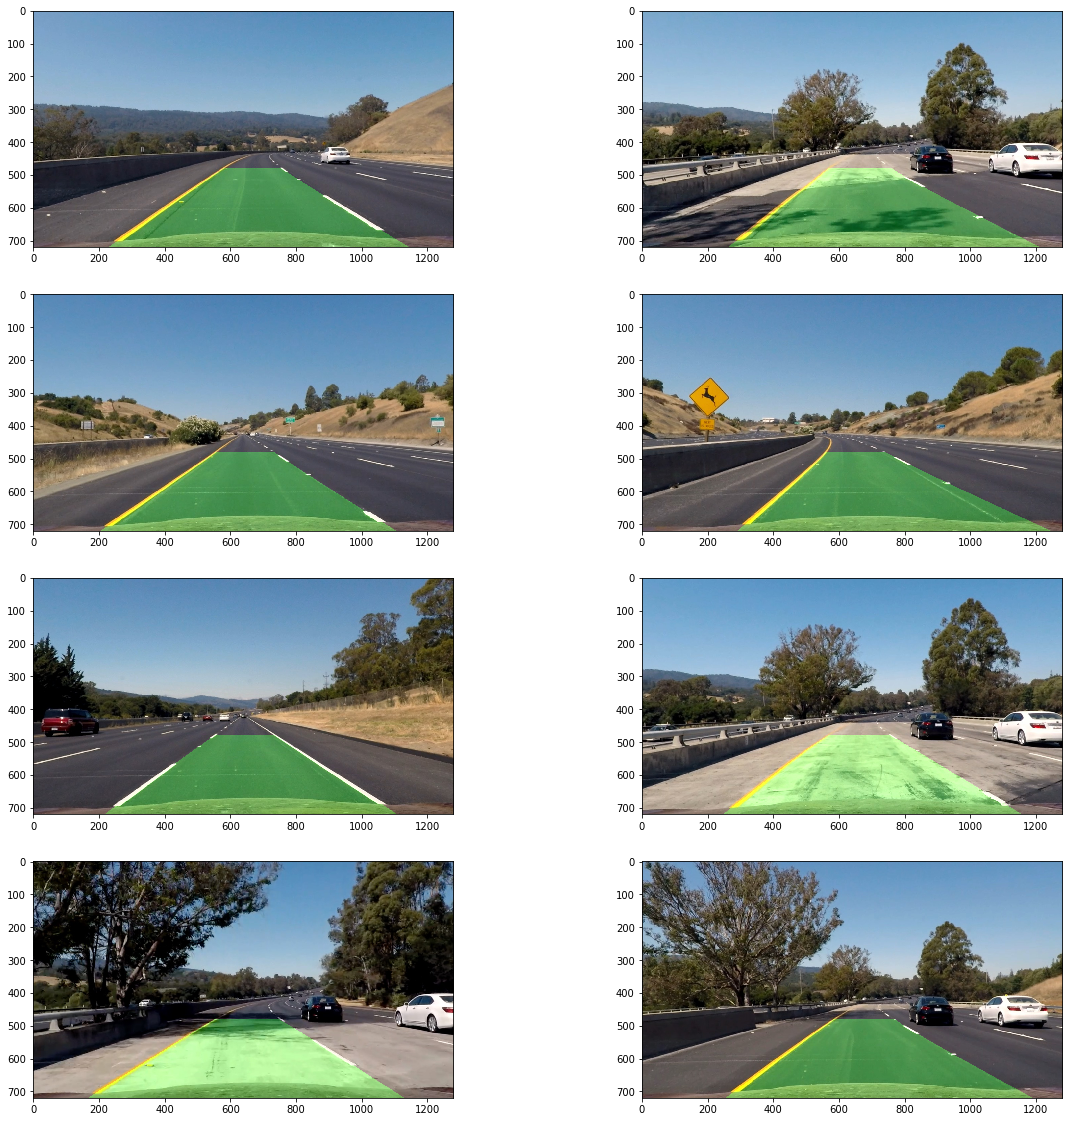

In [15]:
def draw_lines_region(undist_image, warped, left_fitx, right_fitx, ploty,source_points,destinaton_points):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    #Calcultaing unwarped matrix 
    Inv_Warped_matrix = cv2.getPerspectiveTransform(source_points,destinaton_points)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Inv_Warped_matrix, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    image_region_lines = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
    return image_region_lines

fig = plt.figure(figsize=(20, 20))
count = 1
for file in list_images:
    fig.add_subplot(4, 2, count)
    image_full_region_lines = draw_lines_region(undistorted_images['undist_'+file], poly_fit_images['presp_binary_'+file][0], search_around_poly_out['presp_binary_'+file][1], search_around_poly_out['presp_binary_'+file][2], search_around_poly_out['presp_binary_'+file][3],dst,src)
    cool_image = image_full_region_lines
    plt.imshow(cool_image)
    count += 1

In [16]:
#7 CALIING ALL PREVIOUS FUNCTIONS#

In [99]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = [np.array([False])] 
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #polynomial coefficients for the last n fits
        self.n_fits = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = 0 
        #distance in meters of vehicle center from the line
        self.line_base_pos = 0 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #counts the number of the first n loops 
        self.loops_counter = 0
        #counts the number of error of calculation
        self.error_fit = 0

#Calculate average of left and right coeficients
def average_coeficients(left_line_n_fits, right_line_n_fits):
    left_line.best_fit = [np.array([0,0,0])] 
    right_line.best_fit = [np.array([0,0,0])] 
    
    for i in range(left_line_n_fits.shape[0]): 
        left_line.best_fit += left_line_n_fits[i]
    left_line.best_fit = left_line.best_fit / left_line_n_fits.shape[0]
    
    for i in range(right_line_n_fits.shape[0]): 
        right_line.best_fit += right_line_n_fits[i]
    right_line.best_fit = right_line.best_fit / right_line_n_fits.shape[0]


#check if the lines are parallel base on the distance between the top, middle and low points on x axis of the 2 lines
        
def line_distance_comparison(left_fitx, right_fitx):
    
    #distance between lines in pixels 
    dist_btween_lines = 700
    
    #treshhold of parallel lines between x and y
    between_lines_threshhold = 50
    
    if ((right_fitx[len(right_fitx)-1]-left_fitx[len(left_fitx)-1]) > (dist_btween_lines - between_lines_threshhold)) &\
    ((right_fitx[len(right_fitx)-1]-left_fitx[len(left_fitx)-1]) < (dist_btween_lines + between_lines_threshhold)) &\
    ((right_fitx[len(right_fitx)//2]-left_fitx[len(left_fitx)//2]) > (dist_btween_lines - between_lines_threshhold)) &\
    ((right_fitx[len(right_fitx)//2]-left_fitx[len(left_fitx)//2]) < (dist_btween_lines + between_lines_threshhold)) &\
    ((right_fitx[0]-left_fitx[0]) > (dist_btween_lines - between_lines_threshhold)) &\
    ((right_fitx[0]-left_fitx[0]) < (dist_btween_lines + between_lines_threshhold)):
        return True
    else:
        return False
        
def main_call(path_image):

    #define de number of n loops
    n_loops = 5
    
    #treshhold of parallel lines between same line x or
    between_same_lines_threshhold = 10
    
    #thershhold for continues bad calculation of a line fit
    bad_calc_line_threshhold = 2
    
    #Undistort the image and get binary image
    final_binary_image, undist_image  = get_binary_filtered_img(path_image, mtx, dist, saturation_thresh=(180, 255), sobel_thresh=(20, 80), light_thresh=(50,255))
    #generat 3d binary image just for testing
    final_binary_image_3d_format = np.dstack((final_binary_image, final_binary_image, final_binary_image))*255
    
    #Use perspective trasform for eagle view
    final_prespective_image = prespective_transform(final_binary_image,src,dst)
    
    
    if (left_line.detected == False  & right_line.detected == False) :
        print(left_line.detected, right_line.detected)
        #return polyfit for left and right line
        binary_warped, out_img, left_line.current_fit, right_line.current_fit, left_fitx, right_fitx, ploty = fit_polynomial(final_prespective_image)
        left_line.detected = right_line.detected = True
        print_test_image = out_img

    else:
        print(left_line.detected, right_line.detected)
        #draw line band base on polyfit
        result_image_band_line, left_fitx, right_fitx, ploty, left_line.current_fit, right_line.current_fit, \
        left_curve_rad_m, right_curve_rad_m = search_around_poly(final_prespective_image, left_line.current_fit, \
        right_line.current_fit)
        #left_line.detected = right_line.detected = False
        left_line.radius_of_curvature = left_curve_rad_m
        right_line.radius_of_curvature = right_curve_rad_m
        print_test_image = result_image_band_line
    

    
    #Compare the distance in three point bottom, middle and top in Y axis and decide if the they meet the treshholds
    if  left_line.loops_counter == 0 & right_line.loops_counter == 0 :
        left_line.n_fits = np.array([left_line.current_fit])
        right_line.n_fits = np.array([right_line.current_fit])
        left_line.loops_counter += 1
        right_line.loops_counter += 1
        
        
    elif ((left_line.loops_counter < n_loops) & (right_line.loops_counter < n_loops)):
        if line_distance_comparison(left_fitx, right_fitx):
            #add more elements to the matrix of n line coeficcieents
            left_line.n_fits = np.insert(left_line.n_fits, 0,left_line.current_fit, axis=0)
            right_line.n_fits = np.insert(right_line.n_fits, 0,right_line.current_fit, axis=0)
            #increment by 1 until n loops
            left_line.loops_counter += 1
            right_line.loops_counter += 1
            left_line.error_fit = 0
            right_line.error_fit = 0
            print("el chido")
        else:
            #Calculate the value of the x in 0, mid point x and greater point x with the average coeficients for both lines
            y_3_point = np.array([0, final_binary_image.shape[0]//2, final_binary_image.shape[0]-1])
            
            ### Calc both polynomials using ploty, left_fit and right_fit ###
            try:
                #left_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                #right_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                left_fitx_3_points = left_line.best_fit.item(0)*y_3_point**2 + left_line.best_fit.item(1)*y_3_point + left_line.best_fit.item(2)
                right_fitx_3_points = right_line.best_fit.item(0)*y_3_point**2 + right_line.best_fit.item(1)*y_3_point + right_line.best_fit.item(2)
            except TypeError:
                # Avoids an error if `left` and `right_fit` are still none or incorrect
                print('The function failed to fit a line!')
                left_fitx_3_points = 0*y_3_point
                right_fitx_3_points = 0*y_3_point
                left_line.error_fit += 1
                right_line.error_fit += 1
                left_line.current_fit = np.squeeze(left_line.best_fit)
                right_line.current_fit = np.squeeze(right_line.best_fit)
            
            if ((left_fitx[len(left_fitx)-1]) > (left_fitx_3_points.item(2) - between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)-1]) < (left_fitx_3_points.item(2) + between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)//2]) > (left_fitx_3_points.item(1) - between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)//2]) < (left_fitx_3_points.item(1) + between_same_lines_threshhold)) &\
            ((left_fitx[0]) > (left_fitx_3_points.item(0) - between_same_lines_threshhold)) &\
            ((left_fitx[0]) < (left_fitx_3_points.item(0) + between_same_lines_threshhold)):
                #add more elements to the matrix of n line coeficcieents
                left_line.n_fits = np.insert(left_line.n_fits, 0,left_line.current_fit, axis=0)
                left_line.loops_counter += 1
                left_line.error_fit = 0
            else:
                left_line.error_fit += 1
                left_line.current_fit = np.squeeze(left_line.best_fit)
                
            if ((right_fitx[len(right_fitx)-1]) > (right_fitx_3_points.item(2) - between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)-1]) < (right_fitx_3_points.item(2) + between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)//2]) > (right_fitx_3_points.item(1) - between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)//2]) < (right_fitx_3_points.item(1) + between_same_lines_threshhold)) &\
            ((right_fitx[0]) > (right_fitx_3_points.item(0) - between_same_lines_threshhold)) &\
            ((right_fitx[0]) < (right_fitx_3_points.item(0) + between_same_lines_threshhold)):
                #add more elements to the matrix of n line coeficcieents
                right_line.n_fits = np.insert(right_line.n_fits, 0,right_line.current_fit, axis=0)
                right_line.loops_counter += 1
                right_line.error_fit = 0
            else:
                right_line.error_fit += 1
                right_line.current_fit = np.squeeze(right_line.best_fit)
        
 

    elif ((left_line.loops_counter == n_loops) & (right_line.loops_counter < n_loops)):
        if line_distance_comparison(left_fitx, right_fitx):
            #add more elements to the matrix of n line coeficcieents
            left_line.n_fits = np.insert(left_line.n_fits, 0,left_line.current_fit, axis=0)
            right_line.n_fits = np.insert(right_line.n_fits, 0,right_line.current_fit, axis=0)
            #increment by 1 until n loops
            right_line.loops_counter += 1
            left_line.error_fit = 0
            right_line.error_fit = 0
        else:
            #Calculate the value of the x in 0, mid point x and greater point x with the average coeficients for both lines
            y_3_point = np.array([0, final_binary_image.shape[0]//2, final_binary_image.shape[0]-1])
            
            ### Calc both polynomials using ploty, left_fit and right_fit ###
            try:
                #left_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                #right_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                left_fitx_3_points = left_line.best_fit.item(0)*y_3_point**2 + left_line.best_fit.item(1)*y_3_point + left_line.best_fit.item(2)
                right_fitx_3_points = right_line.best_fit.item(0)*y_3_point**2 + right_line.best_fit.item(1)*y_3_point + right_line.best_fit.item(2)
            except TypeError:
                # Avoids an error if `left` and `right_fit` are still none or incorrect
                print('The function failed to fit a line!')
                left_fitx_3_points = 0*y_3_point
                right_fitx_3_points = 0*y_3_point
                left_line.error_fit += 1
                right_line.error_fit += 1
                left_line.current_fit = np.squeeze(left_line.best_fit)
                right_line.current_fit = np.squeeze(right_line.best_fit)
            
            if ((left_fitx[len(left_fitx)-1]) > (left_fitx_3_points.item(2) - between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)-1]) < (left_fitx_3_points.item(2) + between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)//2]) > (left_fitx_3_points.item(1) - between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)//2]) < (left_fitx_3_points.item(1) + between_same_lines_threshhold)) &\
            ((left_fitx[0]) > (left_fitx_3_points.item(0) - between_same_lines_threshhold)) &\
            ((left_fitx[0]) < (left_fitx_3_points.item(0) + between_same_lines_threshhold)):
                #add more elements to the matrix of n line coeficcieents
                left_line.n_fits = np.insert(left_line.n_fits, 0,left_line.current_fit, axis=0)
                left_line.error_fit = 0
            else:
                left_line.error_fit += 1
                left_line.current_fit = np.squeeze(left_line.best_fit)
                
            if ((right_fitx[len(right_fitx)-1]) > (right_fitx_3_points.item(2) - between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)-1]) < (right_fitx_3_points.item(2) + between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)//2]) > (right_fitx_3_points.item(1) - between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)//2]) < (right_fitx_3_points.item(1) + between_same_lines_threshhold)) &\
            ((right_fitx[0]) > (right_fitx_3_points.item(0) - between_same_lines_threshhold)) &\
            ((right_fitx[0]) < (right_fitx_3_points.item(0) + between_same_lines_threshhold)):
                #add more elements to the matrix of n line coeficcieents
                right_line.n_fits = np.insert(right_line.n_fits, 0,right_line.current_fit, axis=0)
                right_line.loops_counter += 1
                right_line.error_fit = 0
            else:
                right_line.error_fit += 1
                right_line.current_fit = np.squeeze(right_line.best_fit)
            
            
    elif ((left_line.loops_counter < n_loops) & (right_line.loops_counter == n_loops)):
        if line_distance_comparison(left_fitx, right_fitx):
            #add more elements to the matrix of n line coeficcieents
            left_line.n_fits = np.insert(left_line.n_fits, 0,left_line.current_fit, axis=0)
            right_line.n_fits = np.insert(right_line.n_fits, 0,right_line.current_fit, axis=0)
            #increment by 1 until n loops
            left_line.loops_counter += 1
            left_line.error_fit = 0
            right_line.error_fit = 0
        else:
            #Calculate the value of the x in 0, mid point x and greater point x with the average coeficients for both lines
            y_3_point = np.array([0, final_binary_image.shape[0]//2, final_binary_image.shape[0]-1])
            
            ### Calc both polynomials using ploty, left_fit and right_fit ###
            try:
                #left_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                #right_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                left_fitx_3_points = left_line.best_fit.item(0)*y_3_point**2 + left_line.best_fit.item(1)*y_3_point + left_line.best_fit.item(2)
                right_fitx_3_points = right_line.best_fit.item(0)*y_3_point**2 + right_line.best_fit.item(1)*y_3_point + right_line.best_fit.item(2)
            except TypeError:
                # Avoids an error if `left` and `right_fit` are still none or incorrect
                print('The function failed to fit a line!')
                left_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                right_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                left_line.error_fit += 1
                right_line.error_fit += 1
                left_line.current_fit = np.squeeze(left_line.best_fit)
                right_line.current_fit = np.squeeze(right_line.best_fit)
            
            if ((left_fitx[len(left_fitx)-1]) > (left_fitx_3_points.item(2) - between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)-1]) < (left_fitx_3_points.item(2) + between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)//2]) > (left_fitx_3_points.item(1) - between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)//2]) < (left_fitx_3_points.item(1) + between_same_lines_threshhold)) &\
            ((left_fitx[0]) > (left_fitx_3_points.item(0) - between_same_lines_threshhold)) &\
            ((left_fitx[0]) < (left_fitx_3_points.item(0) + between_same_lines_threshhold)):
                #add more elements to the matrix of n line coeficcieents
                left_line.n_fits = np.insert(left_line.n_fits, 0,left_line.current_fit, axis=0)
                left_line.loops_counter += 1
                left_line.error_fit = 0
            else:
                left_line.error_fit += 1
                left_line.current_fit = np.squeeze(left_line.best_fit)
                
            if ((right_fitx[len(right_fitx)-1]) > (right_fitx_3_points.item(2) - between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)-1]) < (right_fitx_3_points.item(2) + between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)//2]) > (right_fitx_3_points.item(1) - between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)//2]) < (right_fitx_3_points.item(1) + between_same_lines_threshhold)) &\
            ((right_fitx[0]) > (right_fitx_3_points.item(0) - between_same_lines_threshhold)) &\
            ((right_fitx[0]) < (right_fitx_3_points.item(0) + between_same_lines_threshhold)):
                #add more elements to the matrix of n line coeficcieents
                right_line.n_fits = np.insert(right_line.n_fits, 0,right_line.current_fit, axis=0)
                right_line.error_fit = 0
            else:
                right_line.error_fit += 1
                right_line.current_fit = np.squeeze(right_line.best_fit)


    else:
        if line_distance_comparison(left_fitx, right_fitx):
            #add more elements to the matrix of n line coeficcieents
            left_line.n_fits = np.insert(left_line.n_fits, 0,left_line.current_fit, axis=0)
            right_line.n_fits = np.insert(right_line.n_fits, 0,right_line.current_fit, axis=0)
            left_line.error_fit = 0
            right_line.error_fit = 0
        else:
            #Calculate the value of the x in 0, mid point x and greater point x with the average coeficients for both lines
            y_3_point = np.array([0, final_binary_image.shape[0]//2, final_binary_image.shape[0]-1])
            
            ### Calc both polynomials using ploty, left_fit and right_fit ###
            try:
                #left_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                #right_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                left_fitx_3_points = left_line.best_fit.item(0)*y_3_point**2 + left_line.best_fit.item(1)*y_3_point + left_line.best_fit.item(2)
                right_fitx_3_points = right_line.best_fit.item(0)*y_3_point**2 + right_line.best_fit.item(1)*y_3_point + right_line.best_fit.item(2)
            except TypeError:
                # Avoids an error if `left` and `right_fit` are still none or incorrect
                print('The function failed to fit a line!')
                left_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                right_fitx_3_points = 1*y_3_point**2 + 1*y_3_point
                left_line.error_fit += 1
                right_line.error_fit += 1
                left_line.current_fit = np.squeeze(left_line.best_fit)
                right_line.current_fit = np.squeeze(right_line.best_fit)
            
            if ((left_fitx[len(left_fitx)-1]) > (left_fitx_3_points.item(2) - between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)-1]) < (left_fitx_3_points.item(2) + between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)//2]) > (left_fitx_3_points.item(1) - between_same_lines_threshhold)) &\
            ((left_fitx[len(left_fitx)//2]) < (left_fitx_3_points.item(1) + between_same_lines_threshhold)) &\
            ((left_fitx[0]) > (left_fitx_3_points.item(0) - between_same_lines_threshhold)) &\
            ((left_fitx[0]) < (left_fitx_3_points.item(0) + between_same_lines_threshhold)):
                #add more elements to the matrix of n line coeficcieents
                left_line.n_fits = np.insert(left_line.n_fits, 0,left_line.current_fit, axis=0)
                left_line.error_fit = 0
            else:
                left_line.error_fit += 1
                left_line.current_fit = np.squeeze(left_line.best_fit)
                
            if ((right_fitx[len(right_fitx)-1]) > (right_fitx_3_points.item(2) - between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)-1]) < (right_fitx_3_points.item(2) + between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)//2]) > (right_fitx_3_points.item(1) - between_same_lines_threshhold)) &\
            ((right_fitx[len(right_fitx)//2]) < (right_fitx_3_points.item(1) + between_same_lines_threshhold)) &\
            ((right_fitx[0]) > (right_fitx_3_points.item(0) - between_same_lines_threshhold)) &\
            ((right_fitx[0]) < (right_fitx_3_points.item(0) + between_same_lines_threshhold)):
                #add more elements to the matrix of n line coeficcieents
                right_line.n_fits = np.insert(right_line.n_fits, 0,right_line.current_fit, axis=0)
                right_line.error_fit = 0
            else:
                right_line.error_fit += 1
                right_line.current_fit = np.squeeze(right_line.best_fit)
            
    #calculate the average of the coeficients
    average_coeficients(left_line.n_fits, right_line.n_fits)
            
    if (left_line.error_fit >= bad_calc_line_threshhold) | (right_line.error_fit >= bad_calc_line_threshhold) :
        left_line.detected = right_line.detected = False
            
    #Check which line or line is not calculated correctly and choose the correct coeficient (Ax^2 + Bx + C) used in this loop to plot the image
    
    #If the coeficients are good store them and calculate the average, if not increment count of faluty and use stored average, if the counter is equal to 3 call fit_polynomial function to calculate squares
    
    #Calculate the offset to the center line
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_between_lines = ((right_fitx[len(right_fitx)-1]-left_fitx[len(left_fitx)-1])/2)+left_fitx[len(left_fitx)-1]
    Offset_center_lines = final_binary_image.shape[1]/2 - center_between_lines
    left_line.line_base_pos = right_line.line_base_pos = Offset_center_lines*xm_per_pix

    #draw region in green for undistorted image
    f_image_region_lines = draw_lines_region(undist_image, final_prespective_image, left_fitx, right_fitx, ploty,dst,src)
    
    
    #writing the lines curvature from each line as text in the image
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    leftLineTextPosition = (10,20)
    rightLineTextPosition = (10,50)
    offcetToCenterPosition = (10,80)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2

    cv2.putText(f_image_region_lines,'Curvature left line: '+str(np.round(left_line.radius_of_curvature,2))+ ' m', 
    leftLineTextPosition, 
    font, 
    fontScale,
    fontColor,
    lineType)
    
    cv2.putText(f_image_region_lines,'Curvature right line: '+str(np.round(right_line.radius_of_curvature,2))+ ' m', 
    rightLineTextPosition, 
    font, 
    fontScale,
    fontColor,
    lineType)
    
    cv2.putText(f_image_region_lines,'Offset to center: '+str(np.round(left_line.line_base_pos,2))+ ' m', 
    offcetToCenterPosition, 
    font, 
    fontScale,
    fontColor,
    lineType)
    
    return f_image_region_lines #image_region_lines

left_line = Line()
right_line = Line()

'''
fig = plt.figure(figsize=(20, 20))
count = 1
list_images = os.listdir("test_images/")
for file in list_images:
    path_image = "test_images/"+file
    main_call(path_image)
    print_image = main_call(path_image)
    fig.add_subplot(4, 2, count)
    plt.imshow(print_image)
    count += 1'''
    

input_video = "project_video.mp4"
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(input_video).subclip(0,1)
clip1 = VideoFileClip(input_video)
white_clip = clip1.fl_image(main_call)
white_clip.write_videofile("output_images/"+input_video)

False False
[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing audio in project_videoTEMP_MPY_wvf_snd.mp3
















  0%|          | 0/1112 [00:00<?, ?it/s]













 11%|█         | 120/1112 [00:00<00:00, 1198.88it/s]













 30%|███       | 337/1112 [00:00<00:00, 1384.45it/s]













 53%|█████▎    | 593/1112 [00:00<00:00, 1604.27it/s]













 76%|███████▋  | 848/1112 [00:00<00:00, 1804.25it/s]













 99%|█████████▉| 1104/1112 [00:00<00:00, 1978.71it/s]













100%|██████████| 1112/1112 [00:00<00:00, 2198.75it/s]

[MoviePy] Done.
[MoviePy] Writing video output_images/project_video.mp4
















  0%|          | 0/1261 [00:00<?, ?it/s]













  0%|          | 1/1261 [00:00<02:37,  8.01it/s]

True True
el chido
















  0%|          | 2/1261 [00:00<02:40,  7.86it/s]

True True
el chido
















  0%|          | 3/1261 [00:00<02:37,  7.98it/s]

True True
el chido
















  0%|          | 4/1261 [00:00<02:39,  7.87it/s]

True True
el chido
















  0%|          | 5/1261 [00:00<02:41,  7.79it/s]

True True
















  0%|          | 6/1261 [00:00<02:43,  7.69it/s]

True True
















  1%|          | 7/1261 [00:00<02:47,  7.50it/s]

True True
















  1%|          | 8/1261 [00:01<02:48,  7.45it/s]

True True
















  1%|          | 9/1261 [00:01<02:44,  7.60it/s]

True True
















  1%|          | 10/1261 [00:01<02:41,  7.73it/s]

True True
















  1%|          | 11/1261 [00:01<02:37,  7.91it/s]

True True
















  1%|          | 12/1261 [00:01<02:38,  7.89it/s]

True True
















  1%|          | 13/1261 [00:01<02:43,  7.66it/s]

True True
















  1%|          | 14/1261 [00:01<02:45,  7.55it/s]

True True
















  1%|          | 15/1261 [00:01<02:44,  7.58it/s]

True True
















  1%|▏         | 16/1261 [00:02<02:49,  7.33it/s]

True True
















  1%|▏         | 17/1261 [00:02<02:51,  7.25it/s]

True True
True True
















  1%|▏         | 18/1261 [00:02<02:54,  7.11it/s]













  2%|▏         | 19/1261 [00:02<02:52,  7.20it/s]

True True
True True
















  2%|▏         | 20/1261 [00:02<02:54,  7.12it/s]













  2%|▏         | 21/1261 [00:02<02:56,  7.04it/s]

True True
















  2%|▏         | 22/1261 [00:02<02:52,  7.18it/s]

True True
















  2%|▏         | 23/1261 [00:03<02:39,  7.75it/s]

True True
















  2%|▏         | 24/1261 [00:03<02:36,  7.91it/s]

True True
















  2%|▏         | 25/1261 [00:03<02:37,  7.83it/s]

True True
















  2%|▏         | 26/1261 [00:03<02:36,  7.90it/s]

False False
















  2%|▏         | 27/1261 [00:03<02:37,  7.85it/s]

True True
















  2%|▏         | 28/1261 [00:03<02:41,  7.63it/s]

True True
















  2%|▏         | 29/1261 [00:03<02:46,  7.39it/s]

True True
















  2%|▏         | 30/1261 [00:03<02:51,  7.20it/s]

True True
















  2%|▏         | 31/1261 [00:04<02:47,  7.35it/s]

True True
















  3%|▎         | 32/1261 [00:04<02:50,  7.22it/s]

True True
True True
















  3%|▎         | 33/1261 [00:04<03:09,  6.48it/s]













  3%|▎         | 34/1261 [00:04<02:55,  7.00it/s]

True True


True True


  3%|▎         | 35/1261 [00:04<02:58,  6.87it/s]

True True
















  3%|▎         | 36/1261 [00:04<03:07,  6.53it/s]













  3%|▎         | 37/1261 [00:05<03:02,  6.70it/s]

True True
















  3%|▎         | 38/1261 [00:05<02:57,  6.90it/s]

True True
















  3%|▎         | 39/1261 [00:05<02:54,  7.01it/s]

True True
















  3%|▎         | 40/1261 [00:05<02:52,  7.09it/s]

True True
















  3%|▎         | 41/1261 [00:05<02:48,  7.22it/s]

True True


True True


  3%|▎         | 42/1261 [00:05<02:54,  7.00it/s]













  3%|▎         | 43/1261 [00:05<03:38,  5.58it/s]

True True
















  3%|▎         | 44/1261 [00:06<03:46,  5.38it/s]













  4%|▎         | 45/1261 [00:06<03:17,  6.15it/s]

True True
True True
















  4%|▎         | 46/1261 [00:06<03:02,  6.65it/s]













  4%|▎         | 47/1261 [00:06<02:50,  7.12it/s]

True True
True True
















  4%|▍         | 48/1261 [00:06<02:47,  7.26it/s]













  4%|▍         | 49/1261 [00:06<02:43,  7.42it/s]

True True
True True
















  4%|▍         | 50/1261 [00:06<02:45,  7.31it/s]













  4%|▍         | 51/1261 [00:07<02:43,  7.39it/s]

True True
True True
















  4%|▍         | 52/1261 [00:07<02:59,  6.73it/s]













  4%|▍         | 53/1261 [00:07<02:54,  6.92it/s]

True True
True True
















  4%|▍         | 54/1261 [00:07<02:56,  6.84it/s]















True True
True True


  4%|▍         | 55/1261 [00:07<02:58,  6.77it/s]













  4%|▍         | 56/1261 [00:07<03:03,  6.57it/s]













  5%|▍         | 57/1261 [00:07<02:49,  7.09it/s]

True True
True True
















  5%|▍         | 58/1261 [00:08<02:52,  6.98it/s]













  5%|▍         | 59/1261 [00:08<02:48,  7.11it/s]

True True
True True
















  5%|▍         | 60/1261 [00:08<02:57,  6.78it/s]













  5%|▍         | 61/1261 [00:08<02:56,  6.80it/s]

True True
True True
















  5%|▍         | 62/1261 [00:08<03:00,  6.63it/s]













  5%|▍         | 63/1261 [00:08<02:56,  6.79it/s]

True True
True True
















  5%|▌         | 64/1261 [00:09<03:13,  6.18it/s]













  5%|▌         | 65/1261 [00:09<03:02,  6.54it/s]

True True
True True
















  5%|▌         | 66/1261 [00:09<03:02,  6.55it/s]













  5%|▌         | 67/1261 [00:09<02:58,  6.67it/s]

True True
True True
















  5%|▌         | 68/1261 [00:09<03:07,  6.36it/s]













  5%|▌         | 69/1261 [00:09<02:59,  6.65it/s]

True True
True True
















  6%|▌         | 70/1261 [00:09<03:04,  6.46it/s]













  6%|▌         | 71/1261 [00:10<02:52,  6.88it/s]

True True
True True
















  6%|▌         | 72/1261 [00:10<02:59,  6.61it/s]













  6%|▌         | 73/1261 [00:10<02:53,  6.85it/s]

True True
True True
















  6%|▌         | 74/1261 [00:10<02:49,  7.00it/s]













  6%|▌         | 75/1261 [00:10<02:45,  7.15it/s]

True True
True True
















  6%|▌         | 76/1261 [00:10<03:05,  6.39it/s]













  6%|▌         | 77/1261 [00:10<02:59,  6.59it/s]

True True
True True
















  6%|▌         | 78/1261 [00:11<03:07,  6.32it/s]















True True
True True


  6%|▋         | 79/1261 [00:11<03:07,  6.31it/s]













  6%|▋         | 80/1261 [00:11<03:25,  5.75it/s]













  6%|▋         | 81/1261 [00:11<03:11,  6.18it/s]

True True
True True
















  7%|▋         | 82/1261 [00:11<03:10,  6.18it/s]













  7%|▋         | 83/1261 [00:11<02:55,  6.69it/s]

True True
True True
















  7%|▋         | 84/1261 [00:12<03:08,  6.23it/s]













  7%|▋         | 85/1261 [00:12<03:00,  6.52it/s]

True True
True True
















  7%|▋         | 86/1261 [00:12<02:58,  6.58it/s]













  7%|▋         | 87/1261 [00:12<02:56,  6.66it/s]

True True
True True
















  7%|▋         | 88/1261 [00:12<03:03,  6.39it/s]

True True
















  7%|▋         | 89/1261 [00:13<04:24,  4.43it/s]













  7%|▋         | 90/1261 [00:13<03:56,  4.94it/s]

True True
True True
















  7%|▋         | 91/1261 [00:13<03:46,  5.17it/s]













  7%|▋         | 92/1261 [00:13<03:27,  5.63it/s]

True True
True True
















  7%|▋         | 93/1261 [00:13<03:35,  5.41it/s]

True True
















  7%|▋         | 94/1261 [00:14<03:48,  5.12it/s]













  8%|▊         | 95/1261 [00:14<03:22,  5.75it/s]

True True
True True
















  8%|▊         | 96/1261 [00:14<03:28,  5.59it/s]













  8%|▊         | 97/1261 [00:14<03:15,  5.95it/s]

True True
True True
















  8%|▊         | 98/1261 [00:14<03:13,  6.02it/s]

True True
True True
















  8%|▊         | 99/1261 [00:14<03:16,  5.93it/s]













  8%|▊         | 100/1261 [00:15<03:49,  5.06it/s]

True True
















  8%|▊         | 101/1261 [00:15<03:53,  4.96it/s]

True True
True True
















  8%|▊         | 102/1261 [00:15<03:43,  5.18it/s]













  8%|▊         | 103/1261 [00:15<03:32,  5.45it/s]















True True
True True


  8%|▊         | 104/1261 [00:15<03:20,  5.77it/s]













  8%|▊         | 105/1261 [00:15<03:13,  5.98it/s]

True True
True True
















  8%|▊         | 106/1261 [00:16<03:12,  5.99it/s]













  8%|▊         | 107/1261 [00:16<03:05,  6.24it/s]

True True
True True
















  9%|▊         | 108/1261 [00:16<03:05,  6.23it/s]













  9%|▊         | 109/1261 [00:16<02:56,  6.51it/s]













  9%|▊         | 110/1261 [00:16<02:53,  6.62it/s]

True True
True True
















  9%|▉         | 111/1261 [00:16<02:50,  6.75it/s]

True True
True True
















  9%|▉         | 112/1261 [00:16<02:54,  6.59it/s]













  9%|▉         | 113/1261 [00:17<02:53,  6.63it/s]













  9%|▉         | 114/1261 [00:17<02:49,  6.76it/s]

True True
True True
















  9%|▉         | 115/1261 [00:17<02:50,  6.71it/s]

True True
True True
















  9%|▉         | 116/1261 [00:17<03:08,  6.07it/s]













  9%|▉         | 117/1261 [00:17<03:07,  6.11it/s]

True True
True True
















  9%|▉         | 118/1261 [00:17<03:07,  6.11it/s]













  9%|▉         | 119/1261 [00:18<03:02,  6.25it/s]













 10%|▉         | 120/1261 [00:18<02:59,  6.36it/s]

True True
True True
















 10%|▉         | 121/1261 [00:18<02:48,  6.75it/s]













 10%|▉         | 122/1261 [00:18<02:39,  7.14it/s]

True True
True True
















 10%|▉         | 123/1261 [00:18<02:37,  7.23it/s]

True True
True True
















 10%|▉         | 124/1261 [00:18<02:44,  6.89it/s]













 10%|▉         | 125/1261 [00:18<02:35,  7.31it/s]













 10%|▉         | 126/1261 [00:19<02:26,  7.76it/s]

True True
True True
















 10%|█         | 127/1261 [00:19<02:18,  8.18it/s]













 10%|█         | 128/1261 [00:19<02:27,  7.66it/s]

True True
True True
















 10%|█         | 129/1261 [00:19<02:35,  7.30it/s]













 10%|█         | 130/1261 [00:19<02:31,  7.45it/s]

True True
True True
















 10%|█         | 131/1261 [00:19<02:33,  7.35it/s]

True True
True True
















 10%|█         | 132/1261 [00:19<02:48,  6.69it/s]













 11%|█         | 133/1261 [00:19<02:38,  7.13it/s]













 11%|█         | 134/1261 [00:20<02:33,  7.33it/s]

True True
True True
















 11%|█         | 135/1261 [00:20<02:40,  6.99it/s]

True True
True True
















 11%|█         | 136/1261 [00:20<02:55,  6.43it/s]













 11%|█         | 137/1261 [00:20<02:47,  6.73it/s]













 11%|█         | 138/1261 [00:20<02:42,  6.92it/s]

True True
True True
















 11%|█         | 139/1261 [00:20<02:43,  6.86it/s]













 11%|█         | 140/1261 [00:21<02:43,  6.87it/s]

True True
True True
















 11%|█         | 141/1261 [00:21<02:41,  6.93it/s]

True True
True True
















 11%|█▏        | 142/1261 [00:21<02:46,  6.74it/s]













 11%|█▏        | 143/1261 [00:21<02:45,  6.77it/s]

True True
True True
















 11%|█▏        | 144/1261 [00:21<02:52,  6.46it/s]













 11%|█▏        | 145/1261 [00:21<03:00,  6.18it/s]













 12%|█▏        | 146/1261 [00:21<02:53,  6.42it/s]

True True
True True
















 12%|█▏        | 147/1261 [00:22<02:54,  6.39it/s]

True True
True















 12%|█▏        | 148/1261 [00:22<03:05,  5.99it/s]













 12%|█▏        | 149/1261 [00:22<02:58,  6.23it/s]

 True
True True
















 12%|█▏        | 150/1261 [00:22<02:52,  6.43it/s]













 12%|█▏        | 151/1261 [00:22<02:42,  6.82it/s]

True True
True True
















 12%|█▏        | 152/1261 [00:22<02:49,  6.53it/s]













 12%|█▏        | 153/1261 [00:23<02:39,  6.96it/s]

True True
True True
















 12%|█▏        | 154/1261 [00:23<02:43,  6.78it/s]

True True
True True
















 12%|█▏        | 155/1261 [00:23<02:47,  6.59it/s]













 12%|█▏        | 156/1261 [00:23<03:05,  5.94it/s]

True True
True True
















 12%|█▏        | 157/1261 [00:23<03:06,  5.91it/s]













 13%|█▎        | 158/1261 [00:23<02:56,  6.24it/s]













 13%|█▎        | 159/1261 [00:23<02:47,  6.56it/s]

True True
True True
















 13%|█▎        | 160/1261 [00:24<02:55,  6.28it/s]

True True
True True
















 13%|█▎        | 161/1261 [00:24<02:57,  6.19it/s]













 13%|█▎        | 162/1261 [00:24<02:54,  6.30it/s]













 13%|█▎        | 163/1261 [00:24<02:52,  6.37it/s]

True True
True True
















 13%|█▎        | 164/1261 [00:24<02:49,  6.47it/s]













 13%|█▎        | 165/1261 [00:24<02:44,  6.68it/s]

True True
True True
















 13%|█▎        | 166/1261 [00:25<02:44,  6.64it/s]













 13%|█▎        | 167/1261 [00:25<02:40,  6.81it/s]

True True
True True
















 13%|█▎        | 168/1261 [00:25<02:44,  6.66it/s]













 13%|█▎        | 169/1261 [00:25<02:40,  6.80it/s]

True True
True True
















 13%|█▎        | 170/1261 [00:25<02:37,  6.92it/s]













 14%|█▎        | 171/1261 [00:25<02:35,  6.99it/s]

True True
True True
















 14%|█▎        | 172/1261 [00:25<02:35,  7.02it/s]













 14%|█▎        | 173/1261 [00:26<02:28,  7.31it/s]

True True
True True
















 14%|█▍        | 174/1261 [00:26<02:37,  6.91it/s]













 14%|█▍        | 175/1261 [00:26<02:36,  6.95it/s]

True True
True True
















 14%|█▍        | 176/1261 [00:26<02:40,  6.76it/s]













 14%|█▍        | 177/1261 [00:26<02:35,  6.95it/s]

True True
True True
















 14%|█▍        | 178/1261 [00:26<02:40,  6.73it/s]













 14%|█▍        | 179/1261 [00:26<02:34,  6.99it/s]

True True
True True
















 14%|█▍        | 180/1261 [00:27<02:43,  6.62it/s]

True True
True True
















 14%|█▍        | 181/1261 [00:27<02:43,  6.62it/s]













 14%|█▍        | 182/1261 [00:27<02:43,  6.58it/s]













 15%|█▍        | 183/1261 [00:27<02:32,  7.07it/s]

True True
True True
















 15%|█▍        | 184/1261 [00:27<02:41,  6.65it/s]













 15%|█▍        | 185/1261 [00:27<02:32,  7.06it/s]

True True
True True
















 15%|█▍        | 186/1261 [00:27<02:34,  6.97it/s]

True True
True True
















 15%|█▍        | 187/1261 [00:28<02:41,  6.63it/s]













 15%|█▍        | 188/1261 [00:28<02:50,  6.30it/s]

True True
True True
















 15%|█▍        | 189/1261 [00:28<02:49,  6.33it/s]













 15%|█▌        | 190/1261 [00:28<03:00,  5.93it/s]

True True
True True
















 15%|█▌        | 191/1261 [00:28<03:03,  5.82it/s]













 15%|█▌        | 192/1261 [00:29<03:13,  5.52it/s]













 15%|█▌        | 193/1261 [00:29<02:55,  6.10it/s]

True True
False False
















 15%|█▌        | 194/1261 [00:29<03:13,  5.51it/s]













 15%|█▌        | 195/1261 [00:29<02:59,  5.94it/s]

False False
True True
















 16%|█▌        | 196/1261 [00:29<03:20,  5.32it/s]

True True
True True
















 16%|█▌        | 197/1261 [00:29<03:06,  5.72it/s]













 16%|█▌        | 198/1261 [00:30<02:57,  6.01it/s]













 16%|█▌        | 199/1261 [00:30<02:45,  6.41it/s]

True True
True True
















 16%|█▌        | 200/1261 [00:30<03:29,  5.06it/s]

True True
















 16%|█▌        | 201/1261 [00:30<03:42,  4.76it/s]













 16%|█▌        | 202/1261 [00:30<03:17,  5.36it/s]

False False
False False
















 16%|█▌        | 203/1261 [00:30<03:02,  5.81it/s]

True True
True True
















 16%|█▌        | 204/1261 [00:31<02:59,  5.88it/s]













 16%|█▋        | 205/1261 [00:31<02:48,  6.27it/s]













 16%|█▋        | 206/1261 [00:31<02:39,  6.62it/s]

True True
True True
















 16%|█▋        | 207/1261 [00:31<02:38,  6.66it/s]













 16%|█▋        | 208/1261 [00:31<02:37,  6.68it/s]

True True
True True
















 17%|█▋        | 209/1261 [00:31<02:35,  6.77it/s]













 17%|█▋        | 210/1261 [00:31<02:28,  7.07it/s]

True True
True True
















 17%|█▋        | 211/1261 [00:32<02:28,  7.06it/s]













 17%|█▋        | 212/1261 [00:32<02:28,  7.08it/s]

True True
True True
















 17%|█▋        | 213/1261 [00:32<02:34,  6.80it/s]













 17%|█▋        | 214/1261 [00:32<02:31,  6.92it/s]

True True
True True
















 17%|█▋        | 215/1261 [00:32<02:34,  6.78it/s]

True True
True True
















 17%|█▋        | 216/1261 [00:32<02:50,  6.13it/s]













 17%|█▋        | 217/1261 [00:33<02:44,  6.33it/s]













 17%|█▋        | 218/1261 [00:33<02:39,  6.54it/s]

True True
True True
















 17%|█▋        | 219/1261 [00:33<02:36,  6.68it/s]













 17%|█▋        | 220/1261 [00:33<02:33,  6.79it/s]

True True
True True
















 18%|█▊        | 221/1261 [00:33<02:29,  6.94it/s]













 18%|█▊        | 222/1261 [00:33<02:28,  6.98it/s]

True True
True True
















 18%|█▊        | 223/1261 [00:33<02:21,  7.36it/s]













 18%|█▊        | 224/1261 [00:34<02:21,  7.31it/s]

True True
True True
















 18%|█▊        | 225/1261 [00:34<02:21,  7.34it/s]













 18%|█▊        | 226/1261 [00:34<02:19,  7.39it/s]

True True
True True
















 18%|█▊        | 227/1261 [00:34<02:15,  7.64it/s]













 18%|█▊        | 228/1261 [00:34<02:17,  7.50it/s]

True True
True True
















 18%|█▊        | 229/1261 [00:34<02:18,  7.46it/s]













 18%|█▊        | 230/1261 [00:34<02:22,  7.24it/s]

True True
True True
















 18%|█▊        | 231/1261 [00:34<02:20,  7.32it/s]

True True
True True
















 18%|█▊        | 232/1261 [00:35<02:26,  7.00it/s]













 18%|█▊        | 233/1261 [00:35<02:19,  7.39it/s]













 19%|█▊        | 234/1261 [00:35<02:16,  7.51it/s]

True True
True True
















 19%|█▊        | 235/1261 [00:35<02:21,  7.26it/s]

True True
True True
















 19%|█▊        | 236/1261 [00:35<02:34,  6.64it/s]













 19%|█▉        | 237/1261 [00:35<02:24,  7.07it/s]













 19%|█▉        | 238/1261 [00:35<02:25,  7.04it/s]

True True
True True
















 19%|█▉        | 239/1261 [00:36<02:24,  7.08it/s]

True True
True True
















 19%|█▉        | 240/1261 [00:36<02:32,  6.68it/s]













 19%|█▉        | 241/1261 [00:36<02:32,  6.70it/s]













 19%|█▉        | 242/1261 [00:36<02:27,  6.90it/s]

True True
True True
















 19%|█▉        | 243/1261 [00:36<02:26,  6.93it/s]

True True
True True
















 19%|█▉        | 244/1261 [00:36<02:40,  6.32it/s]













 19%|█▉        | 245/1261 [00:37<02:34,  6.58it/s]













 20%|█▉        | 246/1261 [00:37<02:31,  6.71it/s]

True True
True True
















 20%|█▉        | 247/1261 [00:37<02:33,  6.62it/s]

True True
True True
















 20%|█▉        | 248/1261 [00:37<02:35,  6.52it/s]













 20%|█▉        | 249/1261 [00:37<02:27,  6.88it/s]













 20%|█▉        | 250/1261 [00:37<02:20,  7.21it/s]

True True
True True
















 20%|█▉        | 251/1261 [00:37<02:11,  7.66it/s]













 20%|█▉        | 252/1261 [00:37<02:11,  7.69it/s]

True True
True True
















 20%|██        | 253/1261 [00:38<02:11,  7.65it/s]













 20%|██        | 254/1261 [00:38<02:14,  7.51it/s]

True True
True True
















 20%|██        | 255/1261 [00:38<02:17,  7.30it/s]

True True
True True
















 20%|██        | 256/1261 [00:38<02:29,  6.71it/s]













 20%|██        | 257/1261 [00:38<02:20,  7.14it/s]













 20%|██        | 258/1261 [00:38<02:24,  6.93it/s]

True True
True True
















 21%|██        | 259/1261 [00:38<02:27,  6.79it/s]













 21%|██        | 260/1261 [00:39<02:26,  6.82it/s]

True True
True True
















 21%|██        | 261/1261 [00:39<02:24,  6.93it/s]













 21%|██        | 262/1261 [00:39<02:22,  7.00it/s]

True True
True True
















 21%|██        | 263/1261 [00:39<02:22,  6.99it/s]

True True
True True
















 21%|██        | 264/1261 [00:39<02:35,  6.41it/s]













 21%|██        | 265/1261 [00:39<02:31,  6.59it/s]













 21%|██        | 266/1261 [00:40<02:30,  6.61it/s]

True True
True True
















 21%|██        | 267/1261 [00:40<02:25,  6.82it/s]

True True
True True
















 21%|██▏       | 268/1261 [00:40<02:34,  6.41it/s]













 21%|██▏       | 269/1261 [00:40<02:24,  6.88it/s]













 21%|██▏       | 270/1261 [00:40<02:20,  7.08it/s]

True True
True True
















 21%|██▏       | 271/1261 [00:40<02:24,  6.87it/s]















True True
True True


 22%|██▏       | 272/1261 [00:40<02:28,  6.68it/s]













 22%|██▏       | 273/1261 [00:41<02:22,  6.92it/s]

True True
True True
















 22%|██▏       | 274/1261 [00:41<02:25,  6.77it/s]













 22%|██▏       | 275/1261 [00:41<02:22,  6.91it/s]

True True
True True
















 22%|██▏       | 276/1261 [00:41<02:31,  6.51it/s]













 22%|██▏       | 277/1261 [00:41<02:27,  6.65it/s]













 22%|██▏       | 278/1261 [00:41<02:23,  6.84it/s]

True True
True True
















 22%|██▏       | 279/1261 [00:41<02:20,  6.97it/s]

True True
True True
















 22%|██▏       | 280/1261 [00:42<02:27,  6.65it/s]













 22%|██▏       | 281/1261 [00:42<02:24,  6.79it/s]

True True
True True
















 22%|██▏       | 282/1261 [00:42<02:26,  6.70it/s]













 22%|██▏       | 283/1261 [00:42<02:25,  6.73it/s]

True True
True True
















 23%|██▎       | 284/1261 [00:42<02:34,  6.33it/s]













 23%|██▎       | 285/1261 [00:42<02:30,  6.47it/s]

True True
True True
















 23%|██▎       | 286/1261 [00:43<02:29,  6.53it/s]













 23%|██▎       | 287/1261 [00:43<02:22,  6.83it/s]













 23%|██▎       | 288/1261 [00:43<02:20,  6.92it/s]

True True
True True
















 23%|██▎       | 289/1261 [00:43<02:19,  6.98it/s]













 23%|██▎       | 290/1261 [00:43<02:16,  7.09it/s]

True True
True True
















 23%|██▎       | 291/1261 [00:43<02:15,  7.17it/s]

True True
True True
















 23%|██▎       | 292/1261 [00:43<02:22,  6.79it/s]













 23%|██▎       | 293/1261 [00:44<03:06,  5.19it/s]

True True
True True
















 23%|██▎       | 294/1261 [00:44<02:55,  5.51it/s]













 23%|██▎       | 295/1261 [00:44<02:37,  6.15it/s]













 23%|██▎       | 296/1261 [00:44<02:28,  6.51it/s]

True True
True True
















 24%|██▎       | 297/1261 [00:44<02:24,  6.68it/s]

True True
















 24%|██▎       | 298/1261 [00:44<02:54,  5.50it/s]

True True
True True
















 24%|██▎       | 299/1261 [00:45<02:44,  5.84it/s]













 24%|██▍       | 300/1261 [00:45<02:37,  6.11it/s]













 24%|██▍       | 301/1261 [00:45<02:29,  6.44it/s]

True True
True True
















 24%|██▍       | 302/1261 [00:45<02:43,  5.87it/s]













 24%|██▍       | 303/1261 [00:45<02:33,  6.23it/s]

True True
True True
















 24%|██▍       | 304/1261 [00:45<02:33,  6.22it/s]

True True
















 24%|██▍       | 305/1261 [00:46<02:59,  5.33it/s]

True True
















 24%|██▍       | 306/1261 [00:46<03:21,  4.74it/s]













 24%|██▍       | 307/1261 [00:46<02:58,  5.33it/s]

True True
True True
















 24%|██▍       | 308/1261 [00:46<02:46,  5.71it/s]

True True
True True
















 25%|██▍       | 309/1261 [00:46<02:56,  5.39it/s]













 25%|██▍       | 310/1261 [00:47<02:51,  5.55it/s]













 25%|██▍       | 311/1261 [00:47<02:37,  6.04it/s]

True True
True True
















 25%|██▍       | 312/1261 [00:47<02:33,  6.17it/s]













 25%|██▍       | 313/1261 [00:47<02:24,  6.56it/s]

True True
True True
















 25%|██▍       | 314/1261 [00:47<02:22,  6.65it/s]













 25%|██▍       | 315/1261 [00:47<02:13,  7.11it/s]

True True
True True
















 25%|██▌       | 316/1261 [00:47<02:08,  7.36it/s]













 25%|██▌       | 317/1261 [00:48<02:05,  7.51it/s]

True True
True True
















 25%|██▌       | 318/1261 [00:48<02:12,  7.10it/s]













 25%|██▌       | 319/1261 [00:48<02:09,  7.28it/s]

True True
True True
















 25%|██▌       | 320/1261 [00:48<02:08,  7.33it/s]













 25%|██▌       | 321/1261 [00:48<02:09,  7.25it/s]

True True
True True
















 26%|██▌       | 322/1261 [00:48<02:20,  6.71it/s]

True True
True True
















 26%|██▌       | 323/1261 [00:48<02:26,  6.39it/s]













 26%|██▌       | 324/1261 [00:49<02:18,  6.77it/s]













 26%|██▌       | 325/1261 [00:49<02:14,  6.93it/s]

True True
True True
















 26%|██▌       | 326/1261 [00:49<02:22,  6.56it/s]













 26%|██▌       | 327/1261 [00:49<02:18,  6.75it/s]

True True
True True
















 26%|██▌       | 328/1261 [00:49<02:23,  6.51it/s]

True True
True True
















 26%|██▌       | 329/1261 [00:49<02:25,  6.40it/s]













 26%|██▌       | 330/1261 [00:50<02:49,  5.49it/s]

True True
True True
















 26%|██▌       | 331/1261 [00:50<02:41,  5.75it/s]













 26%|██▋       | 332/1261 [00:50<02:36,  5.93it/s]

True True
True True
















 26%|██▋       | 333/1261 [00:50<02:34,  6.01it/s]













 26%|██▋       | 334/1261 [00:50<02:41,  5.73it/s]













 27%|██▋       | 335/1261 [00:50<02:31,  6.09it/s]

True True
True True
















 27%|██▋       | 336/1261 [00:51<02:26,  6.31it/s]













 27%|██▋       | 337/1261 [00:51<02:20,  6.60it/s]

True True
True True
















 27%|██▋       | 338/1261 [00:51<02:27,  6.25it/s]













 27%|██▋       | 339/1261 [00:51<02:25,  6.34it/s]

True True
True True
















 27%|██▋       | 340/1261 [00:51<02:24,  6.38it/s]













 27%|██▋       | 341/1261 [00:51<02:22,  6.47it/s]

True True
True True
















 27%|██▋       | 342/1261 [00:51<02:26,  6.29it/s]













 27%|██▋       | 343/1261 [00:52<02:19,  6.58it/s]

True True
True True
















 27%|██▋       | 344/1261 [00:52<02:20,  6.53it/s]













 27%|██▋       | 345/1261 [00:52<02:11,  6.96it/s]

True True
True True
















 27%|██▋       | 346/1261 [00:52<02:17,  6.63it/s]

True True
True True
















 28%|██▊       | 347/1261 [00:52<02:22,  6.43it/s]













 28%|██▊       | 348/1261 [00:52<02:22,  6.40it/s]













 28%|██▊       | 349/1261 [00:52<02:17,  6.64it/s]

True True
True True
















 28%|██▊       | 350/1261 [00:53<02:19,  6.55it/s]













 28%|██▊       | 351/1261 [00:53<02:15,  6.72it/s]

True True
True True
















 28%|██▊       | 352/1261 [00:53<02:14,  6.77it/s]













 28%|██▊       | 353/1261 [00:53<02:10,  6.97it/s]

True True
True True
















 28%|██▊       | 354/1261 [00:53<02:10,  6.97it/s]

True True
True True
















 28%|██▊       | 355/1261 [00:53<02:15,  6.71it/s]













 28%|██▊       | 356/1261 [00:54<02:11,  6.89it/s]













 28%|██▊       | 357/1261 [00:54<02:04,  7.24it/s]

True True
True True
















 28%|██▊       | 358/1261 [00:54<02:13,  6.76it/s]













 28%|██▊       | 359/1261 [00:54<02:07,  7.06it/s]

True True
True True
















 29%|██▊       | 360/1261 [00:54<02:08,  7.01it/s]













 29%|██▊       | 361/1261 [00:54<02:04,  7.22it/s]

True True
True True
















 29%|██▊       | 362/1261 [00:54<02:21,  6.35it/s]

True True
True True
















 29%|██▉       | 363/1261 [00:55<02:25,  6.18it/s]













 29%|██▉       | 364/1261 [00:55<02:20,  6.37it/s]

True True
True True
















 29%|██▉       | 365/1261 [00:55<02:17,  6.50it/s]













 29%|██▉       | 366/1261 [00:55<02:15,  6.60it/s]

True True
True True
















 29%|██▉       | 367/1261 [00:55<02:15,  6.61it/s]













 29%|██▉       | 368/1261 [00:55<02:18,  6.47it/s]













 29%|██▉       | 369/1261 [00:55<02:14,  6.64it/s]

True True
True True
















 29%|██▉       | 370/1261 [00:56<02:25,  6.13it/s]













 29%|██▉       | 371/1261 [00:56<02:22,  6.24it/s]

True True
True True
















 30%|██▉       | 372/1261 [00:56<02:22,  6.25it/s]













 30%|██▉       | 373/1261 [00:56<02:19,  6.38it/s]

True True
True True
















 30%|██▉       | 374/1261 [00:56<02:29,  5.92it/s]













 30%|██▉       | 375/1261 [00:56<02:18,  6.38it/s]

True True
True True
















 30%|██▉       | 376/1261 [00:57<02:29,  5.90it/s]













 30%|██▉       | 377/1261 [00:57<02:17,  6.41it/s]

True True
True True
















 30%|██▉       | 378/1261 [00:57<02:27,  6.00it/s]













 30%|███       | 379/1261 [00:57<02:20,  6.28it/s]

True True
True True
















 30%|███       | 380/1261 [00:57<02:16,  6.45it/s]













 30%|███       | 381/1261 [00:57<02:09,  6.81it/s]

True True
True True
















 30%|███       | 382/1261 [00:58<02:19,  6.29it/s]













 30%|███       | 383/1261 [00:58<02:13,  6.60it/s]

True True
True True
















 30%|███       | 384/1261 [00:58<02:09,  6.79it/s]













 31%|███       | 385/1261 [00:58<02:04,  7.03it/s]

True True
True True
















 31%|███       | 386/1261 [00:58<02:04,  7.01it/s]













 31%|███       | 387/1261 [00:58<01:59,  7.29it/s]

True True
True True
















 31%|███       | 388/1261 [00:58<02:00,  7.23it/s]













 31%|███       | 389/1261 [00:59<01:59,  7.28it/s]

True True
True True
















 31%|███       | 390/1261 [00:59<02:10,  6.68it/s]













 31%|███       | 391/1261 [00:59<02:03,  7.05it/s]

True True
True True
















 31%|███       | 392/1261 [00:59<02:06,  6.85it/s]













 31%|███       | 393/1261 [00:59<02:01,  7.14it/s]

True True
True True
















 31%|███       | 394/1261 [00:59<02:07,  6.79it/s]













 31%|███▏      | 395/1261 [00:59<02:07,  6.77it/s]

True True
True True
















 31%|███▏      | 396/1261 [01:00<02:07,  6.78it/s]

True True
True True
















 31%|███▏      | 397/1261 [01:00<02:16,  6.33it/s]













 32%|███▏      | 398/1261 [01:00<02:16,  6.34it/s]













 32%|███▏      | 399/1261 [01:00<02:07,  6.74it/s]

True True
True True
















 32%|███▏      | 400/1261 [01:00<02:17,  6.27it/s]

True True
















 32%|███▏      | 401/1261 [01:00<02:34,  5.55it/s]

True True
True True
















 32%|███▏      | 402/1261 [01:01<02:35,  5.53it/s]













 32%|███▏      | 403/1261 [01:01<02:53,  4.94it/s]

True True
















 32%|███▏      | 404/1261 [01:01<02:57,  4.82it/s]

True True
















 32%|███▏      | 405/1261 [01:01<03:04,  4.64it/s]













 32%|███▏      | 406/1261 [01:01<02:41,  5.30it/s]

True True
True True
















 32%|███▏      | 407/1261 [01:02<02:24,  5.89it/s]













 32%|███▏      | 408/1261 [01:02<02:19,  6.10it/s]

True True
True True
















 32%|███▏      | 409/1261 [01:02<02:16,  6.24it/s]













 33%|███▎      | 410/1261 [01:02<02:11,  6.48it/s]

True True
True True
















 33%|███▎      | 411/1261 [01:02<02:06,  6.73it/s]















True True
True True


 33%|███▎      | 412/1261 [01:02<02:04,  6.80it/s]













 33%|███▎      | 413/1261 [01:02<02:13,  6.38it/s]













 33%|███▎      | 414/1261 [01:03<02:08,  6.57it/s]

True True
True True
















 33%|███▎      | 415/1261 [01:03<02:07,  6.64it/s]













 33%|███▎      | 416/1261 [01:03<02:04,  6.79it/s]

True True
True True
















 33%|███▎      | 417/1261 [01:03<02:04,  6.81it/s]

True True
True True
















 33%|███▎      | 418/1261 [01:03<02:07,  6.63it/s]













 33%|███▎      | 419/1261 [01:03<02:06,  6.66it/s]













 33%|███▎      | 420/1261 [01:04<02:05,  6.68it/s]

True True
True True
















 33%|███▎      | 421/1261 [01:04<02:11,  6.39it/s]

True True
True True
















 33%|███▎      | 422/1261 [01:04<02:12,  6.34it/s]













 34%|███▎      | 423/1261 [01:04<02:12,  6.31it/s]













 34%|███▎      | 424/1261 [01:04<02:07,  6.54it/s]

True True
True True
















 34%|███▎      | 425/1261 [01:04<02:12,  6.33it/s]

True True
True True
















 34%|███▍      | 426/1261 [01:04<02:12,  6.31it/s]













 34%|███▍      | 427/1261 [01:05<02:13,  6.26it/s]













 34%|███▍      | 428/1261 [01:05<02:09,  6.41it/s]

True True
True True
















 34%|███▍      | 429/1261 [01:05<02:14,  6.17it/s]















True True
True True


 34%|███▍      | 430/1261 [01:05<02:13,  6.25it/s]













 34%|███▍      | 431/1261 [01:05<02:11,  6.32it/s]













 34%|███▍      | 432/1261 [01:05<02:06,  6.54it/s]

True True
True True
















 34%|███▍      | 433/1261 [01:06<02:07,  6.50it/s]













 34%|███▍      | 434/1261 [01:06<02:04,  6.62it/s]

True True
True True
















 34%|███▍      | 435/1261 [01:06<02:07,  6.46it/s]

True True
True True
















 35%|███▍      | 436/1261 [01:06<02:15,  6.09it/s]













 35%|███▍      | 437/1261 [01:06<02:23,  5.76it/s]













 35%|███▍      | 438/1261 [01:06<02:13,  6.17it/s]

True True
True True
















 35%|███▍      | 439/1261 [01:07<02:12,  6.22it/s]













 35%|███▍      | 440/1261 [01:07<02:07,  6.45it/s]

True True
True True
















 35%|███▍      | 441/1261 [01:07<02:09,  6.33it/s]













 35%|███▌      | 442/1261 [01:07<02:04,  6.57it/s]

True True
True True
















 35%|███▌      | 443/1261 [01:07<02:04,  6.59it/s]













 35%|███▌      | 444/1261 [01:07<02:01,  6.70it/s]

True True
True True
















 35%|███▌      | 445/1261 [01:07<02:07,  6.38it/s]













 35%|███▌      | 446/1261 [01:08<02:05,  6.49it/s]

True True
True True
















 35%|███▌      | 447/1261 [01:08<02:00,  6.74it/s]













 36%|███▌      | 448/1261 [01:08<01:59,  6.79it/s]

True True
True True
















 36%|███▌      | 449/1261 [01:08<02:06,  6.44it/s]













 36%|███▌      | 450/1261 [01:08<02:02,  6.64it/s]

True True
True True
















 36%|███▌      | 451/1261 [01:08<02:00,  6.71it/s]

True True
True True
















 36%|███▌      | 452/1261 [01:09<02:04,  6.51it/s]













 36%|███▌      | 453/1261 [01:09<02:07,  6.32it/s]















True True
True True


 36%|███▌      | 454/1261 [01:09<02:04,  6.46it/s]













 36%|███▌      | 455/1261 [01:09<02:02,  6.57it/s]

True True
True True
















 36%|███▌      | 456/1261 [01:09<02:05,  6.41it/s]













 36%|███▌      | 457/1261 [01:09<02:08,  6.24it/s]

True True
True True
















 36%|███▋      | 458/1261 [01:09<02:11,  6.08it/s]













 36%|███▋      | 459/1261 [01:10<02:10,  6.16it/s]

True True
True True
















 36%|███▋      | 460/1261 [01:10<02:11,  6.07it/s]













 37%|███▋      | 461/1261 [01:10<02:12,  6.06it/s]

True True
















 37%|███▋      | 462/1261 [01:10<02:26,  5.47it/s]

True True
True True
















 37%|███▋      | 463/1261 [01:10<02:20,  5.67it/s]













 37%|███▋      | 464/1261 [01:11<02:15,  5.86it/s]

True True
True True
















 37%|███▋      | 465/1261 [01:11<02:17,  5.78it/s]













 37%|███▋      | 466/1261 [01:11<02:14,  5.90it/s]

True True
True True
















 37%|███▋      | 467/1261 [01:11<02:15,  5.86it/s]













 37%|███▋      | 468/1261 [01:11<02:15,  5.85it/s]

True True
















 37%|███▋      | 469/1261 [01:12<02:57,  4.47it/s]

True True
















 37%|███▋      | 470/1261 [01:12<03:03,  4.32it/s]

True True
















 37%|███▋      | 471/1261 [01:12<03:06,  4.24it/s]

True True
















 37%|███▋      | 472/1261 [01:12<03:01,  4.34it/s]













 38%|███▊      | 473/1261 [01:12<02:41,  4.89it/s]

True True
True True
















 38%|███▊      | 474/1261 [01:13<02:25,  5.39it/s]













 38%|███▊      | 475/1261 [01:13<02:10,  6.01it/s]

True True
True True
















 38%|███▊      | 476/1261 [01:13<02:11,  5.97it/s]















True True
True True


 38%|███▊      | 477/1261 [01:13<02:08,  6.10it/s]













 38%|███▊      | 478/1261 [01:13<02:05,  6.23it/s]













 38%|███▊      | 479/1261 [01:13<01:56,  6.74it/s]

True True
True True
















 38%|███▊      | 480/1261 [01:13<01:54,  6.83it/s]

True True
True True
















 38%|███▊      | 481/1261 [01:14<01:56,  6.68it/s]













 38%|███▊      | 482/1261 [01:14<01:54,  6.81it/s]

True True
True True
















 38%|███▊      | 483/1261 [01:14<02:05,  6.19it/s]













 38%|███▊      | 484/1261 [01:14<02:28,  5.22it/s]

False False
False False
















 38%|███▊      | 485/1261 [01:14<02:26,  5.29it/s]













 39%|███▊      | 486/1261 [01:14<02:15,  5.71it/s]

True True
















 39%|███▊      | 487/1261 [01:15<02:19,  5.53it/s]

True True
True True
















 39%|███▊      | 488/1261 [01:15<02:22,  5.43it/s]













 39%|███▉      | 489/1261 [01:15<02:15,  5.69it/s]













 39%|███▉      | 490/1261 [01:15<02:06,  6.09it/s]

True True
True True
















 39%|███▉      | 491/1261 [01:15<01:59,  6.43it/s]













 39%|███▉      | 492/1261 [01:15<01:57,  6.56it/s]

True True
True True
















 39%|███▉      | 493/1261 [01:16<01:57,  6.52it/s]













 39%|███▉      | 494/1261 [01:16<01:56,  6.59it/s]

True True
True True
















 39%|███▉      | 495/1261 [01:16<01:53,  6.74it/s]

True True
True True
















 39%|███▉      | 496/1261 [01:16<01:54,  6.67it/s]













 39%|███▉      | 497/1261 [01:16<01:56,  6.58it/s]

True True
















 39%|███▉      | 498/1261 [01:17<02:29,  5.09it/s]













 40%|███▉      | 499/1261 [01:17<02:17,  5.55it/s]

True True
True True
















 40%|███▉      | 500/1261 [01:17<02:07,  5.96it/s]

True True
True True
















 40%|███▉      | 501/1261 [01:17<02:09,  5.86it/s]













 40%|███▉      | 502/1261 [01:17<02:04,  6.11it/s]













 40%|███▉      | 503/1261 [01:17<01:58,  6.39it/s]

True True
False False
















 40%|███▉      | 504/1261 [01:17<02:04,  6.08it/s]

True True
True True
















 40%|████      | 505/1261 [01:18<02:21,  5.36it/s]













 40%|████      | 506/1261 [01:18<02:13,  5.66it/s]

True True
False False
















 40%|████      | 507/1261 [01:18<02:12,  5.70it/s]













 40%|████      | 508/1261 [01:18<02:11,  5.72it/s]

False False
















 40%|████      | 509/1261 [01:18<02:30,  4.98it/s]

True True
True True
















 40%|████      | 510/1261 [01:19<02:17,  5.48it/s]













 41%|████      | 511/1261 [01:19<02:09,  5.79it/s]













 41%|████      | 512/1261 [01:19<02:04,  6.03it/s]

False False
False False
















 41%|████      | 513/1261 [01:19<02:01,  6.15it/s]













 41%|████      | 514/1261 [01:19<01:55,  6.46it/s]

False False
False False
















 41%|████      | 515/1261 [01:19<01:52,  6.65it/s]













 41%|████      | 516/1261 [01:19<01:50,  6.77it/s]

True True
True True
















 41%|████      | 517/1261 [01:20<01:53,  6.54it/s]













 41%|████      | 518/1261 [01:20<01:48,  6.82it/s]

True True
True True
















 41%|████      | 519/1261 [01:20<01:50,  6.69it/s]















True True
True True


 41%|████      | 520/1261 [01:20<01:49,  6.78it/s]













 41%|████▏     | 521/1261 [01:20<02:01,  6.09it/s]













 41%|████▏     | 522/1261 [01:20<01:54,  6.44it/s]

True True
True True
















 41%|████▏     | 523/1261 [01:21<01:54,  6.47it/s]













 42%|████▏     | 524/1261 [01:21<01:50,  6.69it/s]

True True
True True
















 42%|████▏     | 525/1261 [01:21<01:53,  6.47it/s]













 42%|████▏     | 526/1261 [01:21<01:48,  6.79it/s]

True True
True True
















 42%|████▏     | 527/1261 [01:21<01:43,  7.10it/s]













 42%|████▏     | 528/1261 [01:21<01:41,  7.21it/s]

True True
True True
















 42%|████▏     | 529/1261 [01:21<01:50,  6.64it/s]













 42%|████▏     | 530/1261 [01:22<01:46,  6.83it/s]

False False
True True
















 42%|████▏     | 531/1261 [01:22<01:48,  6.70it/s]













 42%|████▏     | 532/1261 [01:22<01:44,  6.98it/s]

True True
True True
















 42%|████▏     | 533/1261 [01:22<01:51,  6.51it/s]













 42%|████▏     | 534/1261 [01:22<01:45,  6.89it/s]

True True
True True
















 42%|████▏     | 535/1261 [01:22<01:42,  7.09it/s]













 43%|████▎     | 536/1261 [01:22<01:40,  7.18it/s]

True True
True True
















 43%|████▎     | 537/1261 [01:23<01:47,  6.77it/s]













 43%|████▎     | 538/1261 [01:23<01:42,  7.04it/s]

True True
True True
















 43%|████▎     | 539/1261 [01:23<01:43,  6.97it/s]

True True
True True
















 43%|████▎     | 540/1261 [01:23<01:48,  6.67it/s]













 43%|████▎     | 541/1261 [01:23<01:50,  6.50it/s]

True True
True True
















 43%|████▎     | 542/1261 [01:23<01:53,  6.32it/s]













 43%|████▎     | 543/1261 [01:24<02:09,  5.53it/s]













 43%|████▎     | 544/1261 [01:24<01:59,  6.00it/s]

True True
True True
















 43%|████▎     | 545/1261 [01:24<01:54,  6.23it/s]













 43%|████▎     | 546/1261 [01:24<01:52,  6.35it/s]

True True
True True
















 43%|████▎     | 547/1261 [01:24<01:48,  6.56it/s]

True True
True True
















 43%|████▎     | 548/1261 [01:24<01:51,  6.38it/s]













 44%|████▎     | 549/1261 [01:24<01:47,  6.59it/s]













 44%|████▎     | 550/1261 [01:25<01:41,  6.97it/s]

True True
True True
















 44%|████▎     | 551/1261 [01:25<01:41,  7.02it/s]













 44%|████▍     | 552/1261 [01:25<01:44,  6.81it/s]

False False
False False
















 44%|████▍     | 553/1261 [01:25<01:40,  7.08it/s]













 44%|████▍     | 554/1261 [01:25<01:37,  7.25it/s]

False False
False False
















 44%|████▍     | 555/1261 [01:25<01:40,  7.01it/s]

False False
False False
















 44%|████▍     | 556/1261 [01:25<01:47,  6.56it/s]













 44%|████▍     | 557/1261 [01:26<01:41,  6.93it/s]













 44%|████▍     | 558/1261 [01:26<01:39,  7.08it/s]

False False
False False
















 44%|████▍     | 559/1261 [01:26<01:40,  6.96it/s]

False False
False False
















 44%|████▍     | 560/1261 [01:26<01:50,  6.35it/s]













 44%|████▍     | 561/1261 [01:26<01:41,  6.88it/s]













 45%|████▍     | 562/1261 [01:26<01:41,  6.92it/s]

False False
False False
















 45%|████▍     | 563/1261 [01:26<01:39,  7.04it/s]

False False
False False
















 45%|████▍     | 564/1261 [01:27<01:45,  6.61it/s]













 45%|████▍     | 565/1261 [01:27<01:36,  7.24it/s]













 45%|████▍     | 566/1261 [01:27<01:31,  7.58it/s]

False False
False False
















 45%|████▍     | 567/1261 [01:27<01:37,  7.12it/s]

False False
True True
















 45%|████▌     | 568/1261 [01:27<01:41,  6.84it/s]













 45%|████▌     | 569/1261 [01:27<01:42,  6.76it/s]

True True
True True
















 45%|████▌     | 570/1261 [01:28<01:49,  6.29it/s]













 45%|████▌     | 571/1261 [01:28<01:49,  6.29it/s]













 45%|████▌     | 572/1261 [01:28<01:48,  6.37it/s]

False False
False False
















 45%|████▌     | 573/1261 [01:28<01:49,  6.29it/s]













 46%|████▌     | 574/1261 [01:28<01:42,  6.71it/s]

False False
False False
















 46%|████▌     | 575/1261 [01:28<01:35,  7.16it/s]













 46%|████▌     | 576/1261 [01:28<01:30,  7.58it/s]

False False
False False
















 46%|████▌     | 577/1261 [01:29<01:37,  7.04it/s]













 46%|████▌     | 578/1261 [01:29<01:34,  7.25it/s]

False False
False False
















 46%|████▌     | 579/1261 [01:29<01:40,  6.76it/s]













 46%|████▌     | 580/1261 [01:29<01:38,  6.94it/s]

False False
False False
















 46%|████▌     | 581/1261 [01:29<01:33,  7.28it/s]













 46%|████▌     | 582/1261 [01:29<01:26,  7.81it/s]

False False
False False
















 46%|████▌     | 583/1261 [01:29<01:28,  7.69it/s]

True True
True True
















 46%|████▋     | 584/1261 [01:29<01:35,  7.07it/s]













 46%|████▋     | 585/1261 [01:30<01:47,  6.26it/s]

True True
True True
















 46%|████▋     | 586/1261 [01:30<01:49,  6.17it/s]













 47%|████▋     | 587/1261 [01:30<01:44,  6.44it/s]

True True
True True
















 47%|████▋     | 588/1261 [01:30<01:48,  6.22it/s]













 47%|████▋     | 589/1261 [01:30<01:44,  6.40it/s]













 47%|████▋     | 590/1261 [01:30<01:44,  6.45it/s]

True True
True True
















 47%|████▋     | 591/1261 [01:31<01:42,  6.55it/s]

False False
False False
















 47%|████▋     | 592/1261 [01:31<01:44,  6.39it/s]













 47%|████▋     | 593/1261 [01:31<01:38,  6.76it/s]













 47%|████▋     | 594/1261 [01:31<01:38,  6.76it/s]

False False
False False
















 47%|████▋     | 595/1261 [01:31<01:33,  7.09it/s]













 47%|████▋     | 596/1261 [01:31<01:33,  7.12it/s]

False False
False False
















 47%|████▋     | 597/1261 [01:31<01:32,  7.16it/s]













 47%|████▋     | 598/1261 [01:32<01:32,  7.16it/s]

False False
False False
















 48%|████▊     | 599/1261 [01:32<01:36,  6.84it/s]













 48%|████▊     | 600/1261 [01:32<01:33,  7.09it/s]

False False
False False
















 48%|████▊     | 601/1261 [01:32<01:45,  6.25it/s]













 48%|████▊     | 602/1261 [01:32<01:38,  6.66it/s]

False False
False False
















 48%|████▊     | 603/1261 [01:32<01:53,  5.80it/s]

False False
















 48%|████▊     | 604/1261 [01:33<02:17,  4.77it/s]













 48%|████▊     | 605/1261 [01:33<02:02,  5.34it/s]

False False
False False
















 48%|████▊     | 606/1261 [01:33<01:58,  5.53it/s]













 48%|████▊     | 607/1261 [01:33<01:51,  5.85it/s]

False False
False False
















 48%|████▊     | 608/1261 [01:33<01:49,  5.96it/s]

False False
False False
















 48%|████▊     | 609/1261 [01:34<01:52,  5.79it/s]













 48%|████▊     | 610/1261 [01:34<01:51,  5.84it/s]













 48%|████▊     | 611/1261 [01:34<01:47,  6.02it/s]

False False
False False
















 49%|████▊     | 612/1261 [01:34<02:32,  4.25it/s]

False False
False False
















 49%|████▊     | 613/1261 [01:34<02:20,  4.63it/s]













 49%|████▊     | 614/1261 [01:35<02:01,  5.35it/s]













 49%|████▉     | 615/1261 [01:35<01:48,  5.98it/s]

False False
False False
















 49%|████▉     | 616/1261 [01:35<01:40,  6.42it/s]













 49%|████▉     | 617/1261 [01:35<01:32,  6.99it/s]

True True
True True
















 49%|████▉     | 618/1261 [01:35<01:32,  6.97it/s]













 49%|████▉     | 619/1261 [01:35<01:28,  7.26it/s]

False False
False False
















 49%|████▉     | 620/1261 [01:35<01:37,  6.56it/s]













 49%|████▉     | 621/1261 [01:35<01:36,  6.62it/s]

True True
True True
















 49%|████▉     | 622/1261 [01:36<01:47,  5.95it/s]













 49%|████▉     | 623/1261 [01:36<01:37,  6.52it/s]

True True
True True
















 49%|████▉     | 624/1261 [01:36<01:37,  6.51it/s]













 50%|████▉     | 625/1261 [01:36<01:30,  7.05it/s]

True True
False False
















 50%|████▉     | 626/1261 [01:36<01:38,  6.43it/s]













 50%|████▉     | 627/1261 [01:36<01:35,  6.63it/s]

True True
True True
















 50%|████▉     | 628/1261 [01:37<01:41,  6.27it/s]













 50%|████▉     | 629/1261 [01:37<01:42,  6.20it/s]

False False
False False
















 50%|████▉     | 630/1261 [01:37<01:42,  6.15it/s]

False False
False False
















 50%|█████     | 631/1261 [01:37<01:41,  6.18it/s]













 50%|█████     | 632/1261 [01:37<01:41,  6.22it/s]













 50%|█████     | 633/1261 [01:37<01:34,  6.67it/s]

False False
False False
















 50%|█████     | 634/1261 [01:38<01:36,  6.50it/s]

False False
False False
















 50%|█████     | 635/1261 [01:38<01:42,  6.09it/s]













 50%|█████     | 636/1261 [01:38<01:42,  6.12it/s]













 51%|█████     | 637/1261 [01:38<01:35,  6.54it/s]

True True
True True
















 51%|█████     | 638/1261 [01:38<01:33,  6.70it/s]













 51%|█████     | 639/1261 [01:38<01:34,  6.59it/s]

True True
True True
















 51%|█████     | 640/1261 [01:38<01:33,  6.62it/s]

True True
True True
















 51%|█████     | 641/1261 [01:39<01:34,  6.57it/s]













 51%|█████     | 642/1261 [01:39<01:36,  6.41it/s]













 51%|█████     | 643/1261 [01:39<01:31,  6.73it/s]

True True
True True
















 51%|█████     | 644/1261 [01:39<01:38,  6.29it/s]













 51%|█████     | 645/1261 [01:39<01:33,  6.62it/s]

True True
True True
















 51%|█████     | 646/1261 [01:39<01:32,  6.63it/s]

True True
True True
















 51%|█████▏    | 647/1261 [01:40<01:34,  6.53it/s]













 51%|█████▏    | 648/1261 [01:40<01:35,  6.40it/s]

True True
True True
















 51%|█████▏    | 649/1261 [01:40<01:37,  6.26it/s]













 52%|█████▏    | 650/1261 [01:40<01:39,  6.13it/s]













 52%|█████▏    | 651/1261 [01:40<01:36,  6.30it/s]

True True
True True
















 52%|█████▏    | 652/1261 [01:40<01:33,  6.49it/s]

True True
True True
















 52%|█████▏    | 653/1261 [01:40<01:33,  6.52it/s]













 52%|█████▏    | 654/1261 [01:41<01:36,  6.32it/s]

True True
True True
















 52%|█████▏    | 655/1261 [01:41<01:39,  6.10it/s]













 52%|█████▏    | 656/1261 [01:41<01:38,  6.17it/s]













 52%|█████▏    | 657/1261 [01:41<01:34,  6.38it/s]

True True
True True
















 52%|█████▏    | 658/1261 [01:41<01:35,  6.30it/s]

True True
True True
















 52%|█████▏    | 659/1261 [01:41<01:37,  6.18it/s]













 52%|█████▏    | 660/1261 [01:42<01:35,  6.30it/s]













 52%|█████▏    | 661/1261 [01:42<01:30,  6.66it/s]

True True
True True
















 52%|█████▏    | 662/1261 [01:42<01:31,  6.52it/s]

True True
True True
















 53%|█████▎    | 663/1261 [01:42<01:37,  6.13it/s]













 53%|█████▎    | 664/1261 [01:42<01:37,  6.14it/s]













 53%|█████▎    | 665/1261 [01:42<01:32,  6.44it/s]

True True
True True
















 53%|█████▎    | 666/1261 [01:43<01:33,  6.35it/s]

True True
True True
















 53%|█████▎    | 667/1261 [01:43<01:37,  6.11it/s]













 53%|█████▎    | 668/1261 [01:43<01:42,  5.79it/s]

True True
True True
















 53%|█████▎    | 669/1261 [01:43<01:41,  5.85it/s]













 53%|█████▎    | 670/1261 [01:43<01:38,  5.99it/s]

True True
True True
















 53%|█████▎    | 671/1261 [01:43<01:36,  6.13it/s]













 53%|█████▎    | 672/1261 [01:44<01:37,  6.06it/s]

True True
True True
















 53%|█████▎    | 673/1261 [01:44<01:36,  6.10it/s]













 53%|█████▎    | 674/1261 [01:44<01:35,  6.15it/s]













 54%|█████▎    | 675/1261 [01:44<01:30,  6.45it/s]

True True
True True
















 54%|█████▎    | 676/1261 [01:44<01:30,  6.44it/s]

True True
True True
















 54%|█████▎    | 677/1261 [01:44<01:32,  6.30it/s]













 54%|█████▍    | 678/1261 [01:45<01:32,  6.33it/s]













 54%|█████▍    | 679/1261 [01:45<01:26,  6.70it/s]

True True
True True
















 54%|█████▍    | 680/1261 [01:45<01:32,  6.30it/s]

True True
True True
















 54%|█████▍    | 681/1261 [01:45<01:31,  6.34it/s]













 54%|█████▍    | 682/1261 [01:45<01:32,  6.23it/s]

True True
True True
















 54%|█████▍    | 683/1261 [01:45<01:33,  6.21it/s]













 54%|█████▍    | 684/1261 [01:45<01:33,  6.17it/s]

True True
True True
















 54%|█████▍    | 685/1261 [01:46<01:34,  6.12it/s]













 54%|█████▍    | 686/1261 [01:46<01:34,  6.07it/s]

True True
True True
















 54%|█████▍    | 687/1261 [01:46<01:33,  6.11it/s]













 55%|█████▍    | 688/1261 [01:46<01:33,  6.11it/s]

True True
True True
















 55%|█████▍    | 689/1261 [01:46<01:30,  6.30it/s]













 55%|█████▍    | 690/1261 [01:46<01:30,  6.32it/s]













 55%|█████▍    | 691/1261 [01:47<01:26,  6.62it/s]

True True
True True
















 55%|█████▍    | 692/1261 [01:47<01:33,  6.11it/s]













 55%|█████▍    | 693/1261 [01:47<01:29,  6.33it/s]

True True
True True
















 55%|█████▌    | 694/1261 [01:47<01:27,  6.46it/s]













 55%|█████▌    | 695/1261 [01:47<01:25,  6.63it/s]

True True
True True
















 55%|█████▌    | 696/1261 [01:47<01:23,  6.76it/s]













 55%|█████▌    | 697/1261 [01:47<01:20,  7.04it/s]

True True
True True
















 55%|█████▌    | 698/1261 [01:48<01:18,  7.19it/s]













 55%|█████▌    | 699/1261 [01:48<01:17,  7.23it/s]

True True
True True
















 56%|█████▌    | 700/1261 [01:48<01:19,  7.02it/s]













 56%|█████▌    | 701/1261 [01:48<01:20,  6.95it/s]

True True
True True
















 56%|█████▌    | 702/1261 [01:48<01:23,  6.72it/s]

True True
True















 56%|█████▌    | 703/1261 [01:48<01:33,  6.00it/s]

 True
















 56%|█████▌    | 704/1261 [01:49<01:41,  5.50it/s]

True True
True True
















 56%|█████▌    | 705/1261 [01:49<01:42,  5.41it/s]













 56%|█████▌    | 706/1261 [01:49<01:37,  5.68it/s]













 56%|█████▌    | 707/1261 [01:49<01:32,  5.98it/s]

True True
True True
















 56%|█████▌    | 708/1261 [01:49<01:30,  6.09it/s]

True True
















 56%|█████▌    | 709/1261 [01:50<01:59,  4.63it/s]













 56%|█████▋    | 710/1261 [01:50<01:46,  5.16it/s]

True True
True True
















 56%|█████▋    | 711/1261 [01:50<01:43,  5.29it/s]

True True
True True
















 56%|█████▋    | 712/1261 [01:50<01:43,  5.32it/s]













 57%|█████▋    | 713/1261 [01:50<01:38,  5.54it/s]

True True
















 57%|█████▋    | 714/1261 [01:51<01:52,  4.86it/s]

True True
















 57%|█████▋    | 715/1261 [01:51<01:47,  5.08it/s]

True True
True True
















 57%|█████▋    | 716/1261 [01:51<01:38,  5.53it/s]













 57%|█████▋    | 717/1261 [01:51<01:29,  6.05it/s]













 57%|█████▋    | 718/1261 [01:51<01:25,  6.32it/s]

True True
True True
















 57%|█████▋    | 719/1261 [01:51<01:24,  6.43it/s]













 57%|█████▋    | 720/1261 [01:51<01:19,  6.78it/s]

True True
True True
















 57%|█████▋    | 721/1261 [01:52<01:19,  6.77it/s]













 57%|█████▋    | 722/1261 [01:52<01:19,  6.81it/s]

True True
True True
















 57%|█████▋    | 723/1261 [01:52<01:22,  6.53it/s]













 57%|█████▋    | 724/1261 [01:52<01:19,  6.74it/s]

True True
True True
















 57%|█████▋    | 725/1261 [01:52<01:17,  6.91it/s]













 58%|█████▊    | 726/1261 [01:52<01:14,  7.21it/s]

True True
True True
















 58%|█████▊    | 727/1261 [01:52<01:19,  6.69it/s]

True True
True True
















 58%|█████▊    | 728/1261 [01:53<01:23,  6.37it/s]













 58%|█████▊    | 729/1261 [01:53<01:23,  6.39it/s]













 58%|█████▊    | 730/1261 [01:53<01:22,  6.45it/s]

True True
True True
















 58%|█████▊    | 731/1261 [01:53<01:18,  6.77it/s]

True True
True True
















 58%|█████▊    | 732/1261 [01:53<01:19,  6.67it/s]













 58%|█████▊    | 733/1261 [01:53<01:19,  6.65it/s]

True True
True True
















 58%|█████▊    | 734/1261 [01:54<01:19,  6.59it/s]













 58%|█████▊    | 735/1261 [01:54<01:26,  6.07it/s]

True True
True True
















 58%|█████▊    | 736/1261 [01:54<01:24,  6.20it/s]













 58%|█████▊    | 737/1261 [01:54<01:21,  6.41it/s]













 59%|█████▊    | 738/1261 [01:54<01:19,  6.61it/s]

True True
True True
















 59%|█████▊    | 739/1261 [01:54<01:20,  6.45it/s]













 59%|█████▊    | 740/1261 [01:54<01:19,  6.57it/s]

True True
True True
















 59%|█████▉    | 741/1261 [01:55<01:18,  6.62it/s]

True True
True True
















 59%|█████▉    | 742/1261 [01:55<01:20,  6.45it/s]













 59%|█████▉    | 743/1261 [01:55<01:20,  6.42it/s]

True True
True True
















 59%|█████▉    | 744/1261 [01:55<01:22,  6.30it/s]













 59%|█████▉    | 745/1261 [01:55<01:22,  6.29it/s]













 59%|█████▉    | 746/1261 [01:55<01:18,  6.57it/s]

True True
True True
















 59%|█████▉    | 747/1261 [01:56<01:20,  6.41it/s]













 59%|█████▉    | 748/1261 [01:56<01:18,  6.52it/s]

True True
True True
















 59%|█████▉    | 749/1261 [01:56<01:16,  6.66it/s]















True True
True True


 59%|█████▉    | 750/1261 [01:56<01:17,  6.59it/s]













 60%|█████▉    | 751/1261 [01:56<01:24,  6.01it/s]

True True
True True
















 60%|█████▉    | 752/1261 [01:56<01:23,  6.12it/s]













 60%|█████▉    | 753/1261 [01:56<01:17,  6.59it/s]













 60%|█████▉    | 754/1261 [01:57<01:13,  6.85it/s]

True True
True True
















 60%|█████▉    | 755/1261 [01:57<01:17,  6.56it/s]













 60%|█████▉    | 756/1261 [01:57<01:14,  6.75it/s]

True True
True True
















 60%|██████    | 757/1261 [01:57<01:12,  6.93it/s]













 60%|██████    | 758/1261 [01:57<01:11,  7.05it/s]

True True
True True
















 60%|██████    | 759/1261 [01:57<01:13,  6.86it/s]















True True
True True


 60%|██████    | 760/1261 [01:58<01:14,  6.71it/s]













 60%|██████    | 761/1261 [01:58<01:14,  6.70it/s]













 60%|██████    | 762/1261 [01:58<01:12,  6.84it/s]

True True
True True
















 61%|██████    | 763/1261 [01:58<01:16,  6.52it/s]

True True
True True
















 61%|██████    | 764/1261 [01:58<01:18,  6.29it/s]













 61%|██████    | 765/1261 [01:58<01:22,  6.00it/s]

True True
True True
















 61%|██████    | 766/1261 [01:58<01:23,  5.94it/s]













 61%|██████    | 767/1261 [01:59<01:19,  6.21it/s]













 61%|██████    | 768/1261 [01:59<01:17,  6.38it/s]

True True
False False
















 61%|██████    | 769/1261 [01:59<01:13,  6.71it/s]













 61%|██████    | 770/1261 [01:59<01:12,  6.81it/s]

False False
True True
















 61%|██████    | 771/1261 [01:59<01:15,  6.51it/s]













 61%|██████    | 772/1261 [01:59<01:13,  6.61it/s]

True True
True True
















 61%|██████▏   | 773/1261 [02:00<01:15,  6.49it/s]















True True
True True


 61%|██████▏   | 774/1261 [02:00<01:14,  6.55it/s]













 61%|██████▏   | 775/1261 [02:00<01:21,  5.96it/s]

True True
True True
















 62%|██████▏   | 776/1261 [02:00<01:23,  5.78it/s]













 62%|██████▏   | 777/1261 [02:00<01:23,  5.77it/s]

True True
True True
















 62%|██████▏   | 778/1261 [02:00<01:26,  5.60it/s]













 62%|██████▏   | 779/1261 [02:01<01:25,  5.63it/s]

True True
True True
















 62%|██████▏   | 780/1261 [02:01<01:22,  5.82it/s]













 62%|██████▏   | 781/1261 [02:01<01:22,  5.85it/s]

True True
True True
















 62%|██████▏   | 782/1261 [02:01<01:20,  5.97it/s]













 62%|██████▏   | 783/1261 [02:01<01:18,  6.12it/s]













 62%|██████▏   | 784/1261 [02:01<01:15,  6.30it/s]

True True
True True
















 62%|██████▏   | 785/1261 [02:02<01:14,  6.39it/s]













 62%|██████▏   | 786/1261 [02:02<01:11,  6.65it/s]

True True
True True
















 62%|██████▏   | 787/1261 [02:02<01:12,  6.56it/s]













 62%|██████▏   | 788/1261 [02:02<01:08,  6.86it/s]

True True
True True
















 63%|██████▎   | 789/1261 [02:02<01:13,  6.43it/s]

True True
True True
















 63%|██████▎   | 790/1261 [02:02<01:15,  6.22it/s]













 63%|██████▎   | 791/1261 [02:03<01:20,  5.82it/s]

True True
















 63%|██████▎   | 792/1261 [02:03<01:27,  5.39it/s]

True True
















 63%|██████▎   | 793/1261 [02:03<01:39,  4.70it/s]

True True
True True
















 63%|██████▎   | 794/1261 [02:03<01:31,  5.08it/s]













 63%|██████▎   | 795/1261 [02:03<01:22,  5.63it/s]













 63%|██████▎   | 796/1261 [02:03<01:15,  6.15it/s]

True True
True True
















 63%|██████▎   | 797/1261 [02:04<01:14,  6.25it/s]

True True
True True
















 63%|██████▎   | 798/1261 [02:04<01:14,  6.17it/s]













 63%|██████▎   | 799/1261 [02:04<01:13,  6.30it/s]

True True
True True
















 63%|██████▎   | 800/1261 [02:04<01:13,  6.30it/s]













 64%|██████▎   | 801/1261 [02:04<01:12,  6.32it/s]

True True
True True
















 64%|██████▎   | 802/1261 [02:04<01:16,  6.02it/s]













 64%|██████▎   | 803/1261 [02:05<01:13,  6.20it/s]

True True
True True
















 64%|██████▍   | 804/1261 [02:05<01:15,  6.07it/s]













 64%|██████▍   | 805/1261 [02:05<01:35,  4.75it/s]

True True
True True
















 64%|██████▍   | 806/1261 [02:05<01:35,  4.76it/s]













 64%|██████▍   | 807/1261 [02:05<01:28,  5.13it/s]

True True
True True
















 64%|██████▍   | 808/1261 [02:06<01:28,  5.12it/s]













 64%|██████▍   | 809/1261 [02:06<01:19,  5.68it/s]

True True
True True
















 64%|██████▍   | 810/1261 [02:06<01:19,  5.66it/s]













 64%|██████▍   | 811/1261 [02:06<01:26,  5.22it/s]

True True
True True
















 64%|██████▍   | 812/1261 [02:06<01:24,  5.31it/s]













 64%|██████▍   | 813/1261 [02:07<01:25,  5.22it/s]

True True
True True
















 65%|██████▍   | 814/1261 [02:07<01:23,  5.38it/s]













 65%|██████▍   | 815/1261 [02:07<01:14,  6.01it/s]

True True
True True
















 65%|██████▍   | 816/1261 [02:07<01:25,  5.19it/s]













 65%|██████▍   | 817/1261 [02:07<01:22,  5.39it/s]

True True
True True
















 65%|██████▍   | 818/1261 [02:07<01:20,  5.49it/s]













 65%|██████▍   | 819/1261 [02:08<01:17,  5.67it/s]

True True
True True
















 65%|██████▌   | 820/1261 [02:08<01:20,  5.50it/s]













 65%|██████▌   | 821/1261 [02:08<01:14,  5.88it/s]

True True
True True
















 65%|██████▌   | 822/1261 [02:08<01:13,  6.00it/s]













 65%|██████▌   | 823/1261 [02:08<01:11,  6.09it/s]

True True
True True
















 65%|██████▌   | 824/1261 [02:08<01:11,  6.09it/s]













 65%|██████▌   | 825/1261 [02:09<01:11,  6.13it/s]

True True
True True
















 66%|██████▌   | 826/1261 [02:09<01:12,  5.98it/s]













 66%|██████▌   | 827/1261 [02:09<01:10,  6.12it/s]

True True
True True
















 66%|██████▌   | 828/1261 [02:09<01:09,  6.23it/s]













 66%|██████▌   | 829/1261 [02:09<01:08,  6.27it/s]

True True
True True
















 66%|██████▌   | 830/1261 [02:09<01:13,  5.84it/s]













 66%|██████▌   | 831/1261 [02:10<01:16,  5.65it/s]

True True
True True
















 66%|██████▌   | 832/1261 [02:10<01:17,  5.56it/s]













 66%|██████▌   | 833/1261 [02:10<01:12,  5.88it/s]

True True
True True
















 66%|██████▌   | 834/1261 [02:10<01:15,  5.64it/s]













 66%|██████▌   | 835/1261 [02:10<01:09,  6.09it/s]













 66%|██████▋   | 836/1261 [02:10<01:05,  6.50it/s]

True True
True True
















 66%|██████▋   | 837/1261 [02:11<01:04,  6.53it/s]













 66%|██████▋   | 838/1261 [02:11<01:04,  6.54it/s]

True True
True True
















 67%|██████▋   | 839/1261 [02:11<01:01,  6.87it/s]















True True
True True


 67%|██████▋   | 840/1261 [02:11<01:02,  6.71it/s]













 67%|██████▋   | 841/1261 [02:11<01:01,  6.78it/s]

True True
True True
















 67%|██████▋   | 842/1261 [02:11<01:08,  6.15it/s]













 67%|██████▋   | 843/1261 [02:11<01:06,  6.24it/s]













 67%|██████▋   | 844/1261 [02:12<01:03,  6.58it/s]

True True
False False
















 67%|██████▋   | 845/1261 [02:12<01:02,  6.64it/s]













 67%|██████▋   | 846/1261 [02:12<01:01,  6.70it/s]

False False
False False
















 67%|██████▋   | 847/1261 [02:12<01:00,  6.89it/s]













 67%|██████▋   | 848/1261 [02:12<01:01,  6.70it/s]

False False
False False
















 67%|██████▋   | 849/1261 [02:12<00:58,  7.03it/s]













 67%|██████▋   | 850/1261 [02:12<00:58,  6.99it/s]

False False
False False
















 67%|██████▋   | 851/1261 [02:13<00:58,  6.98it/s]













 68%|██████▊   | 852/1261 [02:13<00:58,  6.95it/s]

False False
False False
















 68%|██████▊   | 853/1261 [02:13<00:57,  7.07it/s]

True True
True True
















 68%|██████▊   | 854/1261 [02:13<01:01,  6.63it/s]













 68%|██████▊   | 855/1261 [02:13<01:00,  6.70it/s]













 68%|██████▊   | 856/1261 [02:13<00:59,  6.83it/s]

True True
False False
















 68%|██████▊   | 857/1261 [02:13<00:57,  7.04it/s]

False False
















 68%|██████▊   | 858/1261 [02:14<01:22,  4.86it/s]













 68%|██████▊   | 859/1261 [02:14<01:13,  5.47it/s]

False False
True True
















 68%|██████▊   | 860/1261 [02:14<01:07,  5.93it/s]













 68%|██████▊   | 861/1261 [02:14<01:01,  6.50it/s]

True True
False False
















 68%|██████▊   | 862/1261 [02:14<01:01,  6.44it/s]













 68%|██████▊   | 863/1261 [02:14<00:58,  6.82it/s]

False False
False False
















 69%|██████▊   | 864/1261 [02:15<00:59,  6.69it/s]













 69%|██████▊   | 865/1261 [02:15<00:57,  6.94it/s]

True True
True True
















 69%|██████▊   | 866/1261 [02:15<00:57,  6.87it/s]













 69%|██████▉   | 867/1261 [02:15<00:56,  6.92it/s]

False False
False False
















 69%|██████▉   | 868/1261 [02:15<00:56,  6.99it/s]













 69%|██████▉   | 869/1261 [02:15<00:54,  7.14it/s]

False False
False False
















 69%|██████▉   | 870/1261 [02:16<00:56,  6.95it/s]













 69%|██████▉   | 871/1261 [02:16<00:57,  6.79it/s]

False False
False False
















 69%|██████▉   | 872/1261 [02:16<00:56,  6.83it/s]

False False
False False
















 69%|██████▉   | 873/1261 [02:16<00:58,  6.60it/s]













 69%|██████▉   | 874/1261 [02:16<01:01,  6.34it/s]

False False
False False
















 69%|██████▉   | 875/1261 [02:16<01:00,  6.35it/s]













 69%|██████▉   | 876/1261 [02:16<00:57,  6.69it/s]













 70%|██████▉   | 877/1261 [02:17<00:55,  6.92it/s]

False False
False False
















 70%|██████▉   | 878/1261 [02:17<00:56,  6.84it/s]













 70%|██████▉   | 879/1261 [02:17<00:52,  7.32it/s]

False False
False False
















 70%|██████▉   | 880/1261 [02:17<00:50,  7.59it/s]













 70%|██████▉   | 881/1261 [02:17<00:50,  7.58it/s]

False False
False False
















 70%|██████▉   | 882/1261 [02:17<00:54,  6.89it/s]













 70%|███████   | 883/1261 [02:17<00:56,  6.71it/s]

False False
False False
















 70%|███████   | 884/1261 [02:18<00:56,  6.70it/s]













 70%|███████   | 885/1261 [02:18<00:55,  6.80it/s]

False False
False False
















 70%|███████   | 886/1261 [02:18<00:56,  6.60it/s]













 70%|███████   | 887/1261 [02:18<00:56,  6.65it/s]

False False
False False
















 70%|███████   | 888/1261 [02:18<00:56,  6.57it/s]













 70%|███████   | 889/1261 [02:18<00:54,  6.85it/s]

True True
True True
















 71%|███████   | 890/1261 [02:18<00:57,  6.44it/s]













 71%|███████   | 891/1261 [02:19<00:56,  6.51it/s]

True True
True True
















 71%|███████   | 892/1261 [02:19<00:57,  6.46it/s]













 71%|███████   | 893/1261 [02:19<00:53,  6.87it/s]

True True
True True
















 71%|███████   | 894/1261 [02:19<00:53,  6.89it/s]













 71%|███████   | 895/1261 [02:19<00:50,  7.18it/s]

False False
False False
















 71%|███████   | 896/1261 [02:19<00:51,  7.09it/s]













 71%|███████   | 897/1261 [02:19<00:48,  7.46it/s]

False False
False False
















 71%|███████   | 898/1261 [02:20<00:50,  7.21it/s]













 71%|███████▏  | 899/1261 [02:20<00:49,  7.26it/s]

False False
False False
















 71%|███████▏  | 900/1261 [02:20<00:48,  7.40it/s]













 71%|███████▏  | 901/1261 [02:20<00:47,  7.50it/s]

False False
True True
















 72%|███████▏  | 902/1261 [02:20<00:53,  6.66it/s]

True True
















 72%|███████▏  | 903/1261 [02:20<01:09,  5.15it/s]

True True
True True
















 72%|███████▏  | 904/1261 [02:21<01:06,  5.40it/s]













 72%|███████▏  | 905/1261 [02:21<01:02,  5.68it/s]

True True
















 72%|███████▏  | 906/1261 [02:21<01:08,  5.22it/s]

False False
False False
















 72%|███████▏  | 907/1261 [02:21<01:03,  5.53it/s]













 72%|███████▏  | 908/1261 [02:21<00:58,  5.99it/s]

False False
False False
















 72%|███████▏  | 909/1261 [02:21<00:58,  6.05it/s]













 72%|███████▏  | 910/1261 [02:22<00:58,  6.03it/s]













 72%|███████▏  | 911/1261 [02:22<00:55,  6.27it/s]

False False
False False
















 72%|███████▏  | 912/1261 [02:22<00:56,  6.14it/s]

False False
True True
















 72%|███████▏  | 913/1261 [02:22<00:58,  5.94it/s]













 72%|███████▏  | 914/1261 [02:22<01:05,  5.28it/s]

True True
















 73%|███████▎  | 915/1261 [02:23<01:07,  5.09it/s]













 73%|███████▎  | 916/1261 [02:23<01:01,  5.58it/s]

True True
True True
















 73%|███████▎  | 917/1261 [02:23<00:56,  6.11it/s]













 73%|███████▎  | 918/1261 [02:23<00:54,  6.33it/s]

False False
False False
















 73%|███████▎  | 919/1261 [02:23<00:52,  6.49it/s]













 73%|███████▎  | 920/1261 [02:23<00:49,  6.90it/s]

False False
False False
















 73%|███████▎  | 921/1261 [02:23<00:49,  6.85it/s]













 73%|███████▎  | 922/1261 [02:24<00:47,  7.09it/s]

False False
False False
















 73%|███████▎  | 923/1261 [02:24<00:47,  7.12it/s]













 73%|███████▎  | 924/1261 [02:24<00:48,  6.96it/s]

False False
False False
















 73%|███████▎  | 925/1261 [02:24<00:48,  6.96it/s]















False False
True True


 73%|███████▎  | 926/1261 [02:24<00:49,  6.76it/s]













 74%|███████▎  | 927/1261 [02:24<00:50,  6.56it/s]

True True
True True
















 74%|███████▎  | 928/1261 [02:24<00:51,  6.46it/s]













 74%|███████▎  | 929/1261 [02:25<00:52,  6.34it/s]

True True
True True
















 74%|███████▍  | 930/1261 [02:25<00:55,  5.97it/s]













 74%|███████▍  | 931/1261 [02:25<00:52,  6.29it/s]

True True
True True
















 74%|███████▍  | 932/1261 [02:25<00:52,  6.27it/s]













 74%|███████▍  | 933/1261 [02:25<00:49,  6.66it/s]













 74%|███████▍  | 934/1261 [02:25<00:47,  6.88it/s]

True True
True True
















 74%|███████▍  | 935/1261 [02:26<00:51,  6.31it/s]

True True
True True
















 74%|███████▍  | 936/1261 [02:26<00:53,  6.06it/s]













 74%|███████▍  | 937/1261 [02:26<00:51,  6.33it/s]

True True
True True
















 74%|███████▍  | 938/1261 [02:26<00:53,  5.98it/s]













 74%|███████▍  | 939/1261 [02:26<00:51,  6.30it/s]













 75%|███████▍  | 940/1261 [02:26<00:48,  6.66it/s]

True True
True True
















 75%|███████▍  | 941/1261 [02:26<00:47,  6.77it/s]















True True
True True


 75%|███████▍  | 942/1261 [02:27<00:47,  6.68it/s]













 75%|███████▍  | 943/1261 [02:27<00:46,  6.85it/s]













 75%|███████▍  | 944/1261 [02:27<00:44,  7.05it/s]

True True
True True
















 75%|███████▍  | 945/1261 [02:27<00:43,  7.21it/s]













 75%|███████▌  | 946/1261 [02:27<00:44,  7.05it/s]

False False
False False
















 75%|███████▌  | 947/1261 [02:27<00:43,  7.22it/s]













 75%|███████▌  | 948/1261 [02:27<00:43,  7.18it/s]

False False
True True
















 75%|███████▌  | 949/1261 [02:28<00:42,  7.34it/s]

True True
True True
















 75%|███████▌  | 950/1261 [02:28<00:48,  6.45it/s]













 75%|███████▌  | 951/1261 [02:28<00:46,  6.66it/s]













 75%|███████▌  | 952/1261 [02:28<00:45,  6.82it/s]

True True
True True
















 76%|███████▌  | 953/1261 [02:28<00:46,  6.69it/s]

True True
False False
















 76%|███████▌  | 954/1261 [02:28<00:48,  6.28it/s]













 76%|███████▌  | 955/1261 [02:29<00:48,  6.30it/s]













 76%|███████▌  | 956/1261 [02:29<00:46,  6.51it/s]

False False
False False
















 76%|███████▌  | 957/1261 [02:29<00:46,  6.52it/s]

False False
False False
















 76%|███████▌  | 958/1261 [02:29<00:47,  6.32it/s]













 76%|███████▌  | 959/1261 [02:29<00:45,  6.60it/s]













 76%|███████▌  | 960/1261 [02:29<00:43,  6.87it/s]

False False
False False
















 76%|███████▌  | 961/1261 [02:29<00:43,  6.96it/s]

True True
True True
















 76%|███████▋  | 962/1261 [02:30<00:47,  6.26it/s]













 76%|███████▋  | 963/1261 [02:30<00:44,  6.77it/s]















True True
True True


 76%|███████▋  | 964/1261 [02:30<00:44,  6.68it/s]













 77%|███████▋  | 965/1261 [02:30<00:43,  6.78it/s]

True True
True True
















 77%|███████▋  | 966/1261 [02:30<00:45,  6.50it/s]













 77%|███████▋  | 967/1261 [02:30<00:43,  6.78it/s]













 77%|███████▋  | 968/1261 [02:30<00:42,  6.83it/s]

True True
True True
















 77%|███████▋  | 969/1261 [02:31<00:44,  6.53it/s]













 77%|███████▋  | 970/1261 [02:31<00:44,  6.61it/s]

True True
True True
















 77%|███████▋  | 971/1261 [02:31<00:42,  6.76it/s]

True True
True True
















 77%|███████▋  | 972/1261 [02:31<00:43,  6.72it/s]













 77%|███████▋  | 973/1261 [02:31<00:44,  6.51it/s]

True True
















 77%|███████▋  | 974/1261 [02:31<00:49,  5.74it/s]

True True
True True
















 77%|███████▋  | 975/1261 [02:32<00:48,  5.87it/s]













 77%|███████▋  | 976/1261 [02:32<00:49,  5.79it/s]













 77%|███████▋  | 977/1261 [02:32<00:45,  6.28it/s]

True True
True True
















 78%|███████▊  | 978/1261 [02:32<00:47,  5.95it/s]













 78%|███████▊  | 979/1261 [02:32<00:45,  6.23it/s]

True True
True True
















 78%|███████▊  | 980/1261 [02:32<00:44,  6.27it/s]













 78%|███████▊  | 981/1261 [02:33<00:42,  6.62it/s]

True True
False False
















 78%|███████▊  | 982/1261 [02:33<00:44,  6.30it/s]













 78%|███████▊  | 983/1261 [02:33<00:43,  6.45it/s]

True True
True True
















 78%|███████▊  | 984/1261 [02:33<00:40,  6.88it/s]













 78%|███████▊  | 985/1261 [02:33<00:39,  7.06it/s]

True True
True True
















 78%|███████▊  | 986/1261 [02:33<00:42,  6.49it/s]















True True
True True


 78%|███████▊  | 987/1261 [02:33<00:42,  6.50it/s]













 78%|███████▊  | 988/1261 [02:34<00:42,  6.36it/s]

True True
True True
















 78%|███████▊  | 989/1261 [02:34<00:43,  6.18it/s]













 79%|███████▊  | 990/1261 [02:34<00:45,  5.96it/s]













 79%|███████▊  | 991/1261 [02:34<00:43,  6.26it/s]

True True
True True
















 79%|███████▊  | 992/1261 [02:34<00:43,  6.24it/s]













 79%|███████▊  | 993/1261 [02:34<00:41,  6.47it/s]

True True
True True
















 79%|███████▉  | 994/1261 [02:35<00:43,  6.12it/s]













 79%|███████▉  | 995/1261 [02:35<00:40,  6.56it/s]

False False
False False
















 79%|███████▉  | 996/1261 [02:35<00:40,  6.53it/s]













 79%|███████▉  | 997/1261 [02:35<00:37,  6.98it/s]

False False
False False
















 79%|███████▉  | 998/1261 [02:35<00:40,  6.55it/s]













 79%|███████▉  | 999/1261 [02:35<00:38,  6.86it/s]

False False
True True
















 79%|███████▉  | 1000/1261 [02:35<00:38,  6.75it/s]













 79%|███████▉  | 1001/1261 [02:36<00:36,  7.20it/s]

True True
False False
















 79%|███████▉  | 1002/1261 [02:36<00:38,  6.74it/s]













 80%|███████▉  | 1003/1261 [02:36<00:36,  7.04it/s]

False False
False False
















 80%|███████▉  | 1004/1261 [02:36<00:37,  6.91it/s]













 80%|███████▉  | 1005/1261 [02:36<00:35,  7.13it/s]

False False
False False
















 80%|███████▉  | 1006/1261 [02:36<00:40,  6.35it/s]













 80%|███████▉  | 1007/1261 [02:37<00:38,  6.54it/s]

False False
False False
















 80%|███████▉  | 1008/1261 [02:37<00:38,  6.55it/s]

False False
True True
















 80%|████████  | 1009/1261 [02:37<00:41,  6.10it/s]













 80%|████████  | 1010/1261 [02:37<00:43,  5.71it/s]

True True
False False
















 80%|████████  | 1011/1261 [02:37<00:42,  5.89it/s]













 80%|████████  | 1012/1261 [02:37<00:42,  5.86it/s]













 80%|████████  | 1013/1261 [02:38<00:40,  6.17it/s]

False False
False False
















 80%|████████  | 1014/1261 [02:38<00:44,  5.53it/s]

False False
















 80%|████████  | 1015/1261 [02:38<00:58,  4.22it/s]

False False
False False
















 81%|████████  | 1016/1261 [02:38<00:52,  4.64it/s]













 81%|████████  | 1017/1261 [02:38<00:47,  5.12it/s]

False False
False False
















 81%|████████  | 1018/1261 [02:39<00:47,  5.15it/s]













 81%|████████  | 1019/1261 [02:39<00:46,  5.20it/s]

False False
False False
















 81%|████████  | 1020/1261 [02:39<00:45,  5.34it/s]













 81%|████████  | 1021/1261 [02:39<00:43,  5.50it/s]













 81%|████████  | 1022/1261 [02:39<00:39,  5.98it/s]

False False
False False
















 81%|████████  | 1023/1261 [02:39<00:39,  6.10it/s]













 81%|████████  | 1024/1261 [02:40<00:38,  6.13it/s]

False False
False False
















 81%|████████▏ | 1025/1261 [02:40<00:38,  6.11it/s]

False False
















 81%|████████▏ | 1026/1261 [02:40<00:40,  5.79it/s]













 81%|████████▏ | 1027/1261 [02:40<00:38,  6.03it/s]

False False
False False
















 82%|████████▏ | 1028/1261 [02:40<00:42,  5.55it/s]













 82%|████████▏ | 1029/1261 [02:40<00:39,  5.91it/s]

False False
False False
















 82%|████████▏ | 1030/1261 [02:41<00:42,  5.42it/s]













 82%|████████▏ | 1031/1261 [02:41<00:40,  5.71it/s]

False False
False False
















 82%|████████▏ | 1032/1261 [02:41<00:38,  5.99it/s]













 82%|████████▏ | 1033/1261 [02:41<00:35,  6.39it/s]

False False
False False
















 82%|████████▏ | 1034/1261 [02:41<00:35,  6.39it/s]













 82%|████████▏ | 1035/1261 [02:41<00:33,  6.69it/s]

False False
False False
















 82%|████████▏ | 1036/1261 [02:42<00:33,  6.66it/s]













 82%|████████▏ | 1037/1261 [02:42<00:32,  6.83it/s]

False False
True True
















 82%|████████▏ | 1038/1261 [02:42<00:34,  6.56it/s]













 82%|████████▏ | 1039/1261 [02:42<00:33,  6.72it/s]

True True
True True
















 82%|████████▏ | 1040/1261 [02:42<00:32,  6.72it/s]













 83%|████████▎ | 1041/1261 [02:42<00:32,  6.87it/s]

False False
False False
















 83%|████████▎ | 1042/1261 [02:43<00:34,  6.36it/s]













 83%|████████▎ | 1043/1261 [02:43<00:33,  6.44it/s]

False False
False False
















 83%|████████▎ | 1044/1261 [02:43<00:33,  6.46it/s]

True True
True True
















 83%|████████▎ | 1045/1261 [02:43<00:37,  5.79it/s]













 83%|████████▎ | 1046/1261 [02:43<00:37,  5.79it/s]













 83%|████████▎ | 1047/1261 [02:43<00:34,  6.22it/s]

True True
False False
















 83%|████████▎ | 1048/1261 [02:43<00:33,  6.39it/s]













 83%|████████▎ | 1049/1261 [02:44<00:31,  6.68it/s]

False False
False False
















 83%|████████▎ | 1050/1261 [02:44<00:32,  6.57it/s]













 83%|████████▎ | 1051/1261 [02:44<00:31,  6.70it/s]

False False
False False
















 83%|████████▎ | 1052/1261 [02:44<00:30,  6.74it/s]













 84%|████████▎ | 1053/1261 [02:44<00:29,  7.08it/s]

False False
False False
















 84%|████████▎ | 1054/1261 [02:44<00:29,  6.92it/s]













 84%|████████▎ | 1055/1261 [02:44<00:28,  7.13it/s]

False False
False False
















 84%|████████▎ | 1056/1261 [02:45<00:30,  6.76it/s]













 84%|████████▍ | 1057/1261 [02:45<00:29,  6.96it/s]

True True
True True
















 84%|████████▍ | 1058/1261 [02:45<00:30,  6.76it/s]













 84%|████████▍ | 1059/1261 [02:45<00:29,  6.93it/s]

True True
True True
















 84%|████████▍ | 1060/1261 [02:45<00:28,  6.97it/s]













 84%|████████▍ | 1061/1261 [02:45<00:28,  6.90it/s]

True True
True True
















 84%|████████▍ | 1062/1261 [02:46<00:30,  6.52it/s]













 84%|████████▍ | 1063/1261 [02:46<00:30,  6.57it/s]

True True
True True
















 84%|████████▍ | 1064/1261 [02:46<00:28,  6.83it/s]

True True
True True
















 84%|████████▍ | 1065/1261 [02:46<00:29,  6.72it/s]













 85%|████████▍ | 1066/1261 [02:46<00:28,  6.80it/s]













 85%|████████▍ | 1067/1261 [02:46<00:27,  6.95it/s]

True True
True True
















 85%|████████▍ | 1068/1261 [02:46<00:27,  6.97it/s]













 85%|████████▍ | 1069/1261 [02:47<00:27,  7.03it/s]

True True
True True
















 85%|████████▍ | 1070/1261 [02:47<00:29,  6.46it/s]













 85%|████████▍ | 1071/1261 [02:47<00:28,  6.59it/s]

True True
True True
















 85%|████████▌ | 1072/1261 [02:47<00:29,  6.41it/s]

True True
True True
















 85%|████████▌ | 1073/1261 [02:47<00:29,  6.42it/s]













 85%|████████▌ | 1074/1261 [02:47<00:28,  6.53it/s]

True True
False False
















 85%|████████▌ | 1075/1261 [02:47<00:28,  6.55it/s]













 85%|████████▌ | 1076/1261 [02:48<00:28,  6.39it/s]













 85%|████████▌ | 1077/1261 [02:48<00:28,  6.43it/s]

False False
False False
















 85%|████████▌ | 1078/1261 [02:48<00:26,  6.95it/s]













 86%|████████▌ | 1079/1261 [02:48<00:26,  6.91it/s]

False False
True True
















 86%|████████▌ | 1080/1261 [02:48<00:27,  6.66it/s]















True True
True True


 86%|████████▌ | 1081/1261 [02:48<00:26,  6.74it/s]













 86%|████████▌ | 1082/1261 [02:49<00:27,  6.58it/s]













 86%|████████▌ | 1083/1261 [02:49<00:25,  7.02it/s]

True True
False False
















 86%|████████▌ | 1084/1261 [02:49<00:26,  6.80it/s]













 86%|████████▌ | 1085/1261 [02:49<00:25,  6.80it/s]

True True
True True
















 86%|████████▌ | 1086/1261 [02:49<00:28,  6.07it/s]

False False
















 86%|████████▌ | 1087/1261 [02:49<00:28,  6.12it/s]

False False
False False
















 86%|████████▋ | 1088/1261 [02:49<00:29,  5.84it/s]













 86%|████████▋ | 1089/1261 [02:50<00:28,  6.02it/s]

False False
False False
















 86%|████████▋ | 1090/1261 [02:50<00:29,  5.83it/s]













 87%|████████▋ | 1091/1261 [02:50<00:27,  6.14it/s]

True True
True True
















 87%|████████▋ | 1092/1261 [02:50<00:28,  6.03it/s]













 87%|████████▋ | 1093/1261 [02:50<00:27,  6.15it/s]

True True
True True
















 87%|████████▋ | 1094/1261 [02:50<00:28,  5.78it/s]













 87%|████████▋ | 1095/1261 [02:51<00:28,  5.92it/s]

True True
True True
















 87%|████████▋ | 1096/1261 [02:51<00:27,  5.90it/s]













 87%|████████▋ | 1097/1261 [02:51<00:27,  6.05it/s]

True True
True True
















 87%|████████▋ | 1098/1261 [02:51<00:32,  5.06it/s]













 87%|████████▋ | 1099/1261 [02:51<00:31,  5.18it/s]

True True
True True
















 87%|████████▋ | 1100/1261 [02:52<00:28,  5.62it/s]













 87%|████████▋ | 1101/1261 [02:52<00:26,  6.05it/s]















False False
True True


 87%|████████▋ | 1102/1261 [02:52<00:25,  6.15it/s]













 87%|████████▋ | 1103/1261 [02:52<00:25,  6.18it/s]

True True
True True
















 88%|████████▊ | 1104/1261 [02:52<00:26,  6.04it/s]













 88%|████████▊ | 1105/1261 [02:52<00:27,  5.61it/s]

True True
False False
















 88%|████████▊ | 1106/1261 [02:53<00:27,  5.66it/s]













 88%|████████▊ | 1107/1261 [02:53<00:30,  5.12it/s]

True True
















 88%|████████▊ | 1108/1261 [02:53<00:38,  4.02it/s]

True True
















 88%|████████▊ | 1109/1261 [02:54<00:41,  3.65it/s]













 88%|████████▊ | 1110/1261 [02:54<00:35,  4.27it/s]

False False
False False
















 88%|████████▊ | 1111/1261 [02:54<00:32,  4.60it/s]

False False
















 88%|████████▊ | 1112/1261 [02:54<00:33,  4.41it/s]













 88%|████████▊ | 1113/1261 [02:54<00:30,  4.92it/s]

True True
True True
















 88%|████████▊ | 1114/1261 [02:54<00:29,  4.98it/s]

True True
True True
















 88%|████████▊ | 1115/1261 [02:55<00:27,  5.35it/s]













 89%|████████▊ | 1116/1261 [02:55<00:25,  5.60it/s]













 89%|████████▊ | 1117/1261 [02:55<00:24,  6.00it/s]

True True
True True
















 89%|████████▊ | 1118/1261 [02:55<00:23,  6.06it/s]













 89%|████████▊ | 1119/1261 [02:55<00:21,  6.49it/s]

True True
True True
















 89%|████████▉ | 1120/1261 [02:55<00:21,  6.50it/s]













 89%|████████▉ | 1121/1261 [02:55<00:21,  6.65it/s]

True True
True True
















 89%|████████▉ | 1122/1261 [02:56<00:19,  6.96it/s]













 89%|████████▉ | 1123/1261 [02:56<00:19,  7.03it/s]

False False
False False
















 89%|████████▉ | 1124/1261 [02:56<00:19,  6.95it/s]













 89%|████████▉ | 1125/1261 [02:56<00:18,  7.28it/s]

False False
False False
















 89%|████████▉ | 1126/1261 [02:56<00:18,  7.26it/s]













 89%|████████▉ | 1127/1261 [02:56<00:18,  7.23it/s]

False False
False False
















 89%|████████▉ | 1128/1261 [02:56<00:18,  7.08it/s]













 90%|████████▉ | 1129/1261 [02:57<00:18,  6.95it/s]

False False
False False
















 90%|████████▉ | 1130/1261 [02:57<00:18,  7.17it/s]













 90%|████████▉ | 1131/1261 [02:57<00:17,  7.25it/s]

False False
False False
















 90%|████████▉ | 1132/1261 [02:57<00:19,  6.49it/s]













 90%|████████▉ | 1133/1261 [02:57<00:18,  6.82it/s]

False False
False False
















 90%|████████▉ | 1134/1261 [02:57<00:18,  6.90it/s]













 90%|█████████ | 1135/1261 [02:57<00:17,  7.06it/s]

False False
False False
















 90%|█████████ | 1136/1261 [02:58<00:17,  6.95it/s]













 90%|█████████ | 1137/1261 [02:58<00:17,  7.06it/s]

True True
True True
















 90%|█████████ | 1138/1261 [02:58<00:20,  5.87it/s]

True True
True True
















 90%|█████████ | 1139/1261 [02:58<00:20,  6.02it/s]













 90%|█████████ | 1140/1261 [02:58<00:20,  5.98it/s]













 90%|█████████ | 1141/1261 [02:58<00:18,  6.48it/s]

True True
True True
















 91%|█████████ | 1142/1261 [02:59<00:19,  6.13it/s]

True True
True True
















 91%|█████████ | 1143/1261 [02:59<00:19,  6.16it/s]













 91%|█████████ | 1144/1261 [02:59<00:18,  6.27it/s]















True True
True True


 91%|█████████ | 1145/1261 [02:59<00:18,  6.34it/s]













 91%|█████████ | 1146/1261 [02:59<00:17,  6.71it/s]













 91%|█████████ | 1147/1261 [02:59<00:16,  6.72it/s]

True True
True True
















 91%|█████████ | 1148/1261 [03:00<00:17,  6.31it/s]

True True
True True
















 91%|█████████ | 1149/1261 [03:00<00:18,  6.02it/s]













 91%|█████████ | 1150/1261 [03:00<00:18,  5.89it/s]

True True
True True
















 91%|█████████▏| 1151/1261 [03:00<00:18,  5.96it/s]













 91%|█████████▏| 1152/1261 [03:00<00:19,  5.52it/s]

True True
True True
















 91%|█████████▏| 1153/1261 [03:00<00:18,  5.71it/s]













 92%|█████████▏| 1154/1261 [03:01<00:17,  5.99it/s]













 92%|█████████▏| 1155/1261 [03:01<00:16,  6.24it/s]

True True
True True
















 92%|█████████▏| 1156/1261 [03:01<00:16,  6.26it/s]













 92%|█████████▏| 1157/1261 [03:01<00:15,  6.68it/s]

False False
False False
















 92%|█████████▏| 1158/1261 [03:01<00:15,  6.79it/s]













 92%|█████████▏| 1159/1261 [03:01<00:14,  6.99it/s]

False False
False False
















 92%|█████████▏| 1160/1261 [03:01<00:14,  6.81it/s]













 92%|█████████▏| 1161/1261 [03:02<00:13,  7.22it/s]

False False
False False
















 92%|█████████▏| 1162/1261 [03:02<00:14,  6.82it/s]













 92%|█████████▏| 1163/1261 [03:02<00:13,  7.17it/s]

True True
True True
















 92%|█████████▏| 1164/1261 [03:02<00:15,  6.38it/s]

True True
True True
















 92%|█████████▏| 1165/1261 [03:02<00:14,  6.45it/s]













 92%|█████████▏| 1166/1261 [03:02<00:15,  6.21it/s]













 93%|█████████▎| 1167/1261 [03:03<00:14,  6.64it/s]

True True
False False
















 93%|█████████▎| 1168/1261 [03:03<00:13,  6.70it/s]













 93%|█████████▎| 1169/1261 [03:03<00:13,  6.84it/s]

False False
False False
















 93%|█████████▎| 1170/1261 [03:03<00:13,  6.81it/s]













 93%|█████████▎| 1171/1261 [03:03<00:12,  7.06it/s]

True True
True True
















 93%|█████████▎| 1172/1261 [03:03<00:12,  7.08it/s]













 93%|█████████▎| 1173/1261 [03:03<00:12,  7.28it/s]

True True
True True
















 93%|█████████▎| 1174/1261 [03:04<00:13,  6.56it/s]













 93%|█████████▎| 1175/1261 [03:04<00:12,  6.95it/s]

True True
True True
















 93%|█████████▎| 1176/1261 [03:04<00:13,  6.43it/s]













 93%|█████████▎| 1177/1261 [03:04<00:12,  6.68it/s]

True True
True True
















 93%|█████████▎| 1178/1261 [03:04<00:11,  7.01it/s]













 93%|█████████▎| 1179/1261 [03:04<00:11,  7.08it/s]

False False
False False
















 94%|█████████▎| 1180/1261 [03:04<00:12,  6.33it/s]

True True
True True
















 94%|█████████▎| 1181/1261 [03:05<00:12,  6.29it/s]













 94%|█████████▎| 1182/1261 [03:05<00:13,  5.98it/s]

True True
True True
















 94%|█████████▍| 1183/1261 [03:05<00:12,  6.20it/s]













 94%|█████████▍| 1184/1261 [03:05<00:13,  5.55it/s]













 94%|█████████▍| 1185/1261 [03:05<00:12,  5.86it/s]

True True
True True
















 94%|█████████▍| 1186/1261 [03:05<00:12,  6.02it/s]













 94%|█████████▍| 1187/1261 [03:06<00:11,  6.26it/s]

True True
True True
















 94%|█████████▍| 1188/1261 [03:06<00:11,  6.20it/s]













 94%|█████████▍| 1189/1261 [03:06<00:11,  6.49it/s]

False False
True True
















 94%|█████████▍| 1190/1261 [03:06<00:10,  6.59it/s]













 94%|█████████▍| 1191/1261 [03:06<00:09,  7.02it/s]

True True
False False
















 95%|█████████▍| 1192/1261 [03:06<00:10,  6.54it/s]













 95%|█████████▍| 1193/1261 [03:06<00:10,  6.68it/s]

True True
True True
















 95%|█████████▍| 1194/1261 [03:07<00:10,  6.37it/s]

True True
True True
















 95%|█████████▍| 1195/1261 [03:07<00:10,  6.40it/s]













 95%|█████████▍| 1196/1261 [03:07<00:09,  6.54it/s]

True True
True True
















 95%|█████████▍| 1197/1261 [03:07<00:09,  6.45it/s]













 95%|█████████▌| 1198/1261 [03:07<00:09,  6.58it/s]

True True
True True
















 95%|█████████▌| 1199/1261 [03:07<00:10,  6.02it/s]













 95%|█████████▌| 1200/1261 [03:08<00:10,  6.01it/s]













 95%|█████████▌| 1201/1261 [03:08<00:09,  6.53it/s]

True True
False False
















 95%|█████████▌| 1202/1261 [03:08<00:09,  6.37it/s]













 95%|█████████▌| 1203/1261 [03:08<00:08,  6.60it/s]

True True
True True
















 95%|█████████▌| 1204/1261 [03:08<00:08,  6.99it/s]













 96%|█████████▌| 1205/1261 [03:08<00:08,  6.94it/s]

False False
True True
















 96%|█████████▌| 1206/1261 [03:08<00:07,  6.95it/s]















True True
True True


 96%|█████████▌| 1207/1261 [03:09<00:07,  6.82it/s]













 96%|█████████▌| 1208/1261 [03:09<00:11,  4.44it/s]

True True
















 96%|█████████▌| 1209/1261 [03:09<00:11,  4.62it/s]

True True
True True
















 96%|█████████▌| 1210/1261 [03:09<00:10,  4.85it/s]













 96%|█████████▌| 1211/1261 [03:10<00:09,  5.26it/s]

True True
True True
















 96%|█████████▌| 1212/1261 [03:10<00:09,  5.17it/s]













 96%|█████████▌| 1213/1261 [03:10<00:08,  5.59it/s]













 96%|█████████▋| 1214/1261 [03:10<00:07,  5.90it/s]

True True
True True
















 96%|█████████▋| 1215/1261 [03:10<00:07,  6.19it/s]

True True
True True
















 96%|█████████▋| 1216/1261 [03:10<00:07,  5.74it/s]













 97%|█████████▋| 1217/1261 [03:11<00:07,  6.17it/s]













 97%|█████████▋| 1218/1261 [03:11<00:06,  6.31it/s]

True True
True True
















 97%|█████████▋| 1219/1261 [03:11<00:06,  6.44it/s]

True True
True True
















 97%|█████████▋| 1220/1261 [03:11<00:06,  6.24it/s]













 97%|█████████▋| 1221/1261 [03:11<00:06,  6.02it/s]

True True
True True
















 97%|█████████▋| 1222/1261 [03:11<00:06,  6.10it/s]













 97%|█████████▋| 1223/1261 [03:11<00:05,  6.53it/s]













 97%|█████████▋| 1224/1261 [03:12<00:05,  6.48it/s]

False False
True True
















 97%|█████████▋| 1225/1261 [03:12<00:05,  6.46it/s]













 97%|█████████▋| 1226/1261 [03:12<00:05,  6.57it/s]

True True
True True
















 97%|█████████▋| 1227/1261 [03:12<00:05,  6.50it/s]

True True
True True
















 97%|█████████▋| 1228/1261 [03:12<00:05,  6.41it/s]













 97%|█████████▋| 1229/1261 [03:12<00:04,  6.64it/s]

True True
True True
















 98%|█████████▊| 1230/1261 [03:13<00:04,  6.61it/s]













 98%|█████████▊| 1231/1261 [03:13<00:04,  6.85it/s]

True True
True True
















 98%|█████████▊| 1232/1261 [03:13<00:04,  6.33it/s]













 98%|█████████▊| 1233/1261 [03:13<00:04,  6.96it/s]













 98%|█████████▊| 1234/1261 [03:13<00:03,  7.23it/s]

False False
False False
















 98%|█████████▊| 1235/1261 [03:13<00:03,  7.06it/s]

False False
False False
















 98%|█████████▊| 1236/1261 [03:13<00:03,  6.63it/s]













 98%|█████████▊| 1237/1261 [03:14<00:03,  6.87it/s]













 98%|█████████▊| 1238/1261 [03:14<00:03,  6.98it/s]

False False
False False
















 98%|█████████▊| 1239/1261 [03:14<00:03,  6.38it/s]

False False
















 98%|█████████▊| 1240/1261 [03:14<00:03,  5.75it/s]

True True
True True
















 98%|█████████▊| 1241/1261 [03:14<00:03,  5.84it/s]













 98%|█████████▊| 1242/1261 [03:15<00:03,  5.03it/s]

True True
















 99%|█████████▊| 1243/1261 [03:15<00:03,  4.94it/s]

True True
















 99%|█████████▊| 1244/1261 [03:15<00:03,  4.69it/s]













 99%|█████████▊| 1245/1261 [03:15<00:03,  5.32it/s]

True True
False False
















 99%|█████████▉| 1246/1261 [03:15<00:03,  4.80it/s]

False False
















 99%|█████████▉| 1247/1261 [03:16<00:03,  4.07it/s]

False False
True True
















 99%|█████████▉| 1248/1261 [03:16<00:02,  4.44it/s]













 99%|█████████▉| 1249/1261 [03:16<00:02,  4.97it/s]

True True
True True
















 99%|█████████▉| 1250/1261 [03:16<00:02,  5.40it/s]













 99%|█████████▉| 1251/1261 [03:16<00:01,  5.36it/s]

True True
True 















 99%|█████████▉| 1252/1261 [03:17<00:01,  5.19it/s]

True
True True
















 99%|█████████▉| 1253/1261 [03:17<00:01,  5.31it/s]













 99%|█████████▉| 1254/1261 [03:17<00:01,  5.50it/s]

True True
True True
















100%|█████████▉| 1255/1261 [03:17<00:01,  5.70it/s]













100%|█████████▉| 1256/1261 [03:17<00:00,  5.57it/s]













100%|█████████▉| 1257/1261 [03:17<00:00,  5.81it/s]

False False
False False
















100%|█████████▉| 1258/1261 [03:18<00:00,  5.88it/s]

True True
True True
















100%|█████████▉| 1259/1261 [03:18<00:00,  5.98it/s]













100%|█████████▉| 1260/1261 [03:18<00:00,  5.86it/s]















True True
[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

